# Data Analysis of a Radioactive Particle Tracking System and a Calibration of the NaI detector used
Done by: Sebastian Sarasti

## What is a radiation detector?

A radiation detector is a device which is able to generate pulses-counts for a specific energy value.

The radiation detector measures a fraction of all radiation emitted from the radiactive source.

## Data loading and importing basic modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
from utils import netcount, spectrum, normalizar_exp, area, f_correcion, reso

Load experimental data into dictionaries

In [2]:
# cesium
cs_e = {'5cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21-Cs137-5cm-45min.TKA'),
        '10cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21-Cs137-10cm-109min.TKA'),
        '15cm': np.loadtxt('./Cal-exp-data/DetectorNaI31mar21-Cs137-15cm-217min.TKA')}
# cobalt
co_e = {'5cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21-Co60-5cm-31min.TKA'),
        '10cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21Co-60-10cm-72min.TKA'),
        '15cm': np.loadtxt('./Cal-exp-data/DetectorNaI31mar21-Co-60-15cm-141min.TKA')}
# europium
eu_e = {'5cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21Eu152-5cm-7min.TKA'),
        '10cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21Eu152-10cm-18min.TKA'),
        '15cm': np.loadtxt('./Cal-exp-data/DetectorNaI31mar21-Eu152-15cm-39min.TKA')}
# americium
am_e = {'5cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21-Am241-5cm-8min.TKA'),
        '10cm': np.loadtxt('./Cal-exp-data/DetectorNaI30mar21-Am241-10cm-23min.TKA'),
        '15cm': np.loadtxt('./Cal-exp-data/DetectorNaI31mar21-Am241-15cm-51min.TKA')}

## Channel calibration

The channel calibration is a step in the radiation detector calibration. This step transform the channels into energy.

This analysis is based on the idea that isotopes have defined energy to emitte the radiaction. For example, the Cs-137 only emitts at 662 keV, while the Co-60 at 1173 keV and 1332 keV

Text(0.05, 0.95, '$R^2=1.0000$\n$b=-15.7459$\n$m=0.2161$')

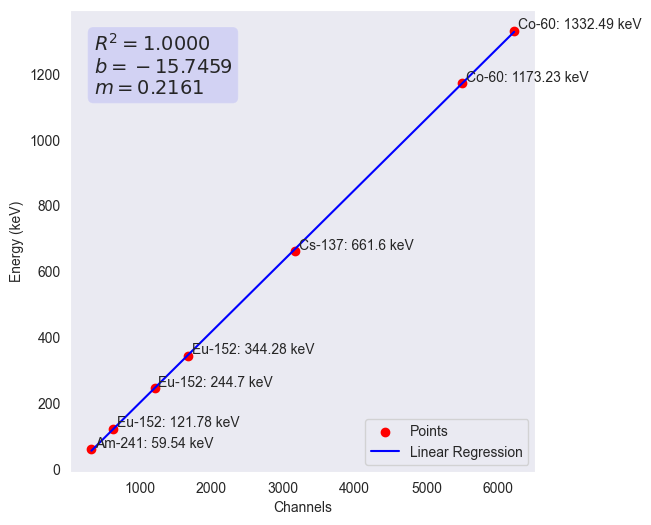

In [3]:
#create channels and convert them to energy
# getting calibration curve
energia_ = np.array([59.5, 122, 245, 344, 662, 1173, 1332])  #kev
ca = np.array([327, 633, 1208, 1678, 3165, 5501, 6222])  #channels
ener_name = ['Am-241: 59.54 keV', 'Eu-152: 121.78 keV', 'Eu-152: 244.7 keV', 'Eu-152: 344.28 keV', 'Cs-137: 661.6 keV', 'Co-60: 1173.23 keV', 'Co-60: 1332.49 keV']
from scipy import stats

res = stats.linregress(ca, energia_)
# save values of regression as text
r2 = res[2]
m_ = res[0]
b_ = res[1]
textstr = '\n'.join((
    r'$R^2=%.4f$' % (r2,),
    r'$b=%.4f$' % (b_,),
    r'$m=%.4f$' % (m_,)))
# plot results of regression
fig2 = plt.figure(figsize=(6, 6))
ax = plt.axes()
trans_ca = lambda x: res[0] * x + res[1]
plt.scatter(ca, energia_, color='r', label='Points')
plt.plot(ca, trans_ca(ca), color='b', label='Linear Regression')
plt.grid()
plt.xlabel('Channels')
plt.ylabel('Energy (keV)')
plt.legend(loc=4)
props = dict(boxstyle='round', facecolor='blue', alpha=0.1)
for i in range(len(ener_name)):
    ax.text(ca[i]+50, energia_[i]+5, ener_name[i])
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

The data shows that the channel calibration can be done through a linear regression.

In [4]:
# Then, it was created a vector for it
canal = np.linspace(1, 8190, 8190)
Energy = np.array([((i * 0.2157 - 11.88) * 0.001) for i in canal])

See the results before the channel calibration

Text(0, 0.5, 'Counts')

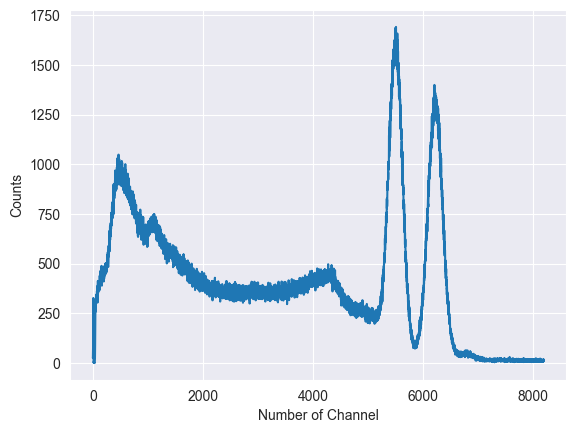

In [5]:
plt.plot(canal, co_e['5cm'][2:])
plt.xlabel('Number of Channel')
plt.ylabel('Counts')

See the results after the channel calibration

Text(0, 0.5, 'Counts')

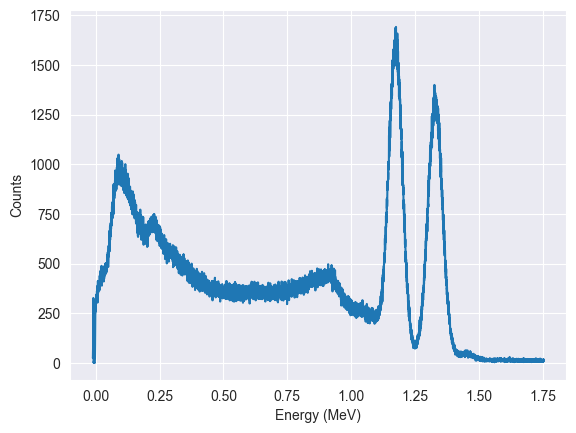

In [6]:
plt.plot(Energy, co_e['5cm'][2:])
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')

After the channel calibration the spectra are going to be transformed into net count rate spectra

This process is done by dividing each bin  per the acquisition time

In [7]:
# get net spectra
cs_e_n = {'5cm': [], '10cm': [], '15cm': []}
co_e_n = {'5cm': [], '10cm': [], '15cm': []}
eu_e_n = {'5cm': [], '10cm': [], '15cm': []}
am_e_n = {'5cm': [], '10cm': [], '15cm': []}
bk = np.loadtxt("./Cal-exp-data/DetectorNaI21oct20fondo2hFuer.txt")
for i in cs_e_n:
    cs_e_n[i] = netcount(cs_e[i], bk)
    co_e_n[i] = netcount(co_e[i], bk)
    eu_e_n[i] = netcount(eu_e[i], bk)
    am_e_n[i] = netcount(am_e[i], bk)

## Full Energy Peak Calibration

The Full Energy Peak Energy (FEPE) Calibration is a process where is measured how many particles are effectively detected by the radiation detector.

In simple words, the radiation detector is just able to detect a short fraction of all particle emitted. So, it is needed to estimate this fraction-percentage by FEPE.

1. It is going to be calculated the activity of the radioactive source in the measurement day. This is because the radioactive source decreases the particle emmited with the time.

In [8]:
# determination of theoretical activity per each source
import radioactivedecay as rd
from datetime import datetime, date, time, timedelta
import calendar

hl = []
hl.append(rd.DEFAULTDATA.half_life('Cs-137', 'd'))
hl.append(rd.DEFAULTDATA.half_life('Eu-152', 'd'))
hl.append(rd.DEFAULTDATA.half_life('Co-60', 'd'))
hl.append(rd.DEFAULTDATA.half_life('Am-241', 'd'))
# Determination of days between the initial time and the date of the measurement are calculated
formato_fecha = "%d-%m-%Y"
# days for Cs137
fecha_inicial = datetime.strptime("01-05-2015", formato_fecha)
fecha_final = datetime.strptime("30-03-2021", formato_fecha)
diferencia = []
diferencia.append(fecha_final - fecha_inicial)
# days for  Eu152
fecha_inicial = datetime.strptime("01-06-2015", formato_fecha)
fecha_final = datetime.strptime("30-03-2021", formato_fecha)
diferencia.append((fecha_final - fecha_inicial))
# days for Co60
fecha_inicial = datetime.strptime("01-06-2015", formato_fecha)
fecha_final = datetime.strptime("30-03-2021", formato_fecha)
diferencia.append((fecha_final - fecha_inicial))
# days for Am-241
fecha_inicial = datetime.strptime("01-04-1988", formato_fecha)
fecha_final = datetime.strptime("30-03-2021", formato_fecha)
diferencia.append((fecha_final - fecha_inicial))
# difference in days
diferencia = [diferencia[i].days for i in range(len(diferencia))]
# initial activities in uCi
act0 = [0.25, 1, 1, 1.054]
# determination of final activities
actf = [act0[i] * np.exp(-np.log(2) * diferencia[i] / hl[i]) for i in range(len(act0))]
actf = [actividad * 37000 for actividad in actf]
activi = pd.Series(data=actf, index=("Cs-137", "Eu-152", "Co-60", "Am-241"))

2. The activity is going to be scaled for each particl detected. This is because radioactive sources emittes at different energies. For instance, 70% at 600 keV and the 30% at 800 keV.

In [9]:
# determination of theoretical gamma counts for each source
cs_t = actf[0] * 0.8499
eu_t = actf[1] * 0.2831
eu_t_1 = actf[1] * 0.0749
eu_t_2 = actf[1] * 0.266
co_t_1 = actf[2] * 0.9988
co_t_2 = actf[2] * 1
am_t = actf[3] * 0.3592
cuentas_t = []
cuentas_t.append(am_t)
cuentas_t.append(eu_t)
cuentas_t.append(eu_t_1)
cuentas_t.append(eu_t_2)
cuentas_t.append(cs_t)
cuentas_t.append(co_t_1)
cuentas_t.append(co_t_2)

3. With the area under a photopeak is determine the counts emitted per second

In [10]:
# determination of area below each photopeak
areas = pd.DataFrame(columns=['Cs-137', 'Eu-152', 'Co-60 1.17 MeV', 'Co-60 1.33 MeV', 'Am-241'], index=range(3))
a_cs137 = [area(cs_e_n[i], Energy, 2800, 3600) for i in cs_e_n]
a_eu152 = [area(eu_e_n[i], Energy, 550, 700) for i in eu_e_n]
a_eu152_1 = [area(eu_e_n[i], Energy, 1100, 1300) for i in eu_e_n]
a_eu152_2 = [area(eu_e_n[i], Energy, 1500, 1900) for i in eu_e_n]
a_co60_1 = [area(co_e_n[i], Energy, 5100, 5800) for i in co_e_n]
a_co60_2 = [area(co_e_n[i], Energy, 5800, 6600) for i in co_e_n]
a_am241 = [area(am_e_n[i], Energy, 250, 400) for i in am_e_n]
areas['Cs-137'] = a_cs137
areas['Eu-152'] = a_eu152
areas['Co-60 1.17 MeV'] = a_co60_1
areas['Co-60 1.33 MeV'] = a_co60_2
areas['Am-241'] = a_am241

In [11]:
areas.head()

,Cs-137,Eu-152,Co-60 1.17 MeV,Co-60 1.33 MeV,Am-241
0,0.044349,0.126200,0.061512,0.051224,0.232881
1,0.016729,0.047339,0.023968,0.019997,0.077336
2,0.008731,0.024100,0.012552,0.010509,0.037211


In [12]:
# save in a matrix the theoretical counts
cuentas_d = np.zeros((3, 7))
for i in range(3):
    cuentas_d[i, 0] = a_am241[i]  #primera columna cuentas para el am-241
    cuentas_d[i, 1] = a_eu152[i]  #primera columna cuentas para el eu-152
    cuentas_d[i, 2] = a_eu152_1[i]  #primera columna cuentas para el eu-152
    cuentas_d[i, 3] = a_eu152_2[i]  #primera columna cuentas para el eu-152
    cuentas_d[i, 4] = a_cs137[i]  #primera columna cuentas para el cs137
    cuentas_d[i, 5] = a_co60_1[i]  #primera columna cuentas para el co-60 1.17 MeV
    cuentas_d[i, 6] = a_co60_2[i]  #primera columna cuentas para el co-60 1.3 MeV

4. Determine the FEPE

> FEPE = detected counts / particle emitted

In [13]:
# create a matrix for efficiencies
eficiencia = np.zeros((3, 7))
for j in range(len(cuentas_t)):
    for i in range(cuentas_d.shape[0]):
        eficiencia[i, j] = (cuentas_d[i, j] / cuentas_t[j]) * 100
    # create a dataframe with efficiencies
efi = pd.DataFrame(columns=(
    "Am-241 59 keV", "Eu-152 121 keV", "Eu-152 244 keV", "Eu-152 344 keV", "Cs-137 662 keV", "Co-60 1.17 MeV",
    "Co-60 1.33 MeV"))
efi["Am-241 59 keV"] = eficiencia[:, 0]
efi["Eu-152 121 keV"] = eficiencia[:, 1]
efi["Eu-152 244 keV"] = eficiencia[:, 2]
efi["Eu-152 344 keV"] = eficiencia[:, 3]
efi["Cs-137 662 keV"] = eficiencia[:, 4]
efi["Co-60 1.17 MeV"] = eficiencia[:, 5]
efi["Co-60 1.33 MeV"] = eficiencia[:, 6]

In [14]:
efi.head()

,Am-241 59 keV,Eu-152 121 keV,Eu-152 244 keV,Eu-152 344 keV,Cs-137 662 keV,Co-60 1.17 MeV,Co-60 1.33 MeV
0,0.001753,0.001624,0.001639,0.001263,0.000646,0.000358,0.000298
1,0.000582,0.000609,0.000673,0.000473,0.000244,0.000140,0.000116
2,0.000280,0.000310,0.000359,0.000242,0.000127,0.000073,0.000061


See the results of the FEPE calibration

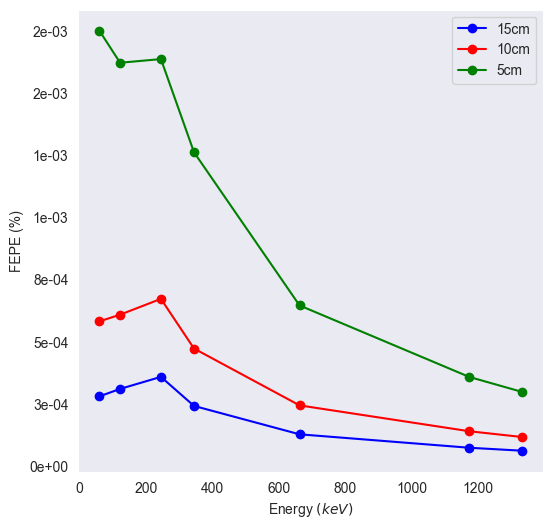

In [15]:
# plot FEPE vs energy
import matplotlib.ticker as mtick

e_cab = [59.5, 121.78, 244.69, 344.28, 662, 1173, 1332]
fig1 = plt.figure(figsize=(6, 6))
ax1 = plt.axes()
ax1.plot(e_cab, eficiencia[2, :], 'o-b', label='15cm')
ax1.plot(e_cab, eficiencia[1, :], 'o-r', label='10cm')
ax1.plot(e_cab, eficiencia[0, :], 'o-g', label='5cm')
plt.legend()
ax1.set_ylabel("FEPE (%)")
ax1.set_xlabel("Energy $(keV)$")
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
#plt.title("Curva de calibración de eficiencias")
ax1.grid()

The last image shows that increasing the particle energy decreases the particle detected.

In addition, another pattern was found. Increasing the distance from the radiation detector decreases the particles detected.

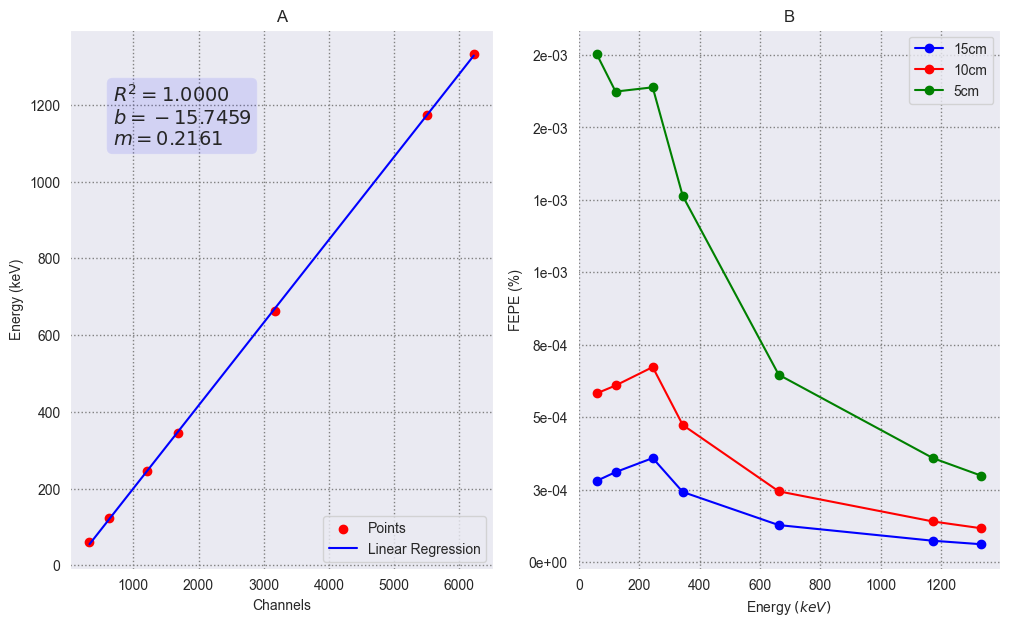

In [96]:
#plot in just one graph channel calibration and FEPE calibration
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 7))
ax3[0].scatter(ca, energia_, color='r', label='Points')
ax3[0].plot(ca, trans_ca(ca), color='b', label='Linear Regression')
ax3[0].grid(linestyle=':', color='grey', linewidth='1') 
ax3[0].set_xlabel('Channels')
ax3[0].set_ylabel('Energy (keV)')
ax3[0].legend(loc=4)
ax3[0].set_title('A')
props = dict(boxstyle='round', facecolor='blue', alpha=0.1)
ax3[1].plot(e_cab, eficiencia[2, :], 'o-b', label='15cm')
ax3[1].plot(e_cab, eficiencia[1, :], 'o-r', label='10cm')
ax3[1].plot(e_cab, eficiencia[0, :], 'o-g', label='5cm')
ax3[1].set_title('B')
ax3[1].legend()
ax3[1].set_ylabel("FEPE (%)")
ax3[1].set_xlabel("Energy $(keV)$")
ax3[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax3[1].grid(linestyle=':', color='grey', linewidth='1')
plt.text(0.1, 0.9, textstr, transform=ax3[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.savefig('channel_FEPE_curves.jpg', dpi=300)

## Calibration with simulated data

Load simulated data

In [17]:
# load simulated data

# cesium
cs_s = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_cs137_1.dat'),
        '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_cs137_2.dat'),
        '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_cs137_3.dat')}
# cobalt
co_s = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_co60_1.dat'),
        '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_co60_2.dat'),
        '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_co60_3.dat')}
# americium
am_s = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_am241_1.dat'),
        '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_am241_2.dat'),
        '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_am241_3.dat')}
#europium
eu_s1 = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p1_1.dat'),
         '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p1_2.dat'),
         '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p1_3.dat')}
eu_s2 = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p2_1.dat'),
         '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p2_2.dat'),
         '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p2_3.dat')}
eu_s3 = {'5cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p3_1.dat'),
         '10cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p3_2.dat'),
         '15cm': np.loadtxt('./Cal-sim-data/' + 'NaIDetector_eu152p3_3.dat')}

The data comes in a histogram format, this is not an efficient way to deal with data.

The data is going to be transform into energy vs counts vector. Also, it was added the spectrum resolution

In [18]:
"""
for key in cs_s:
    cs_s[key]=reso(cs_s[key],0.026)
    co_s[key]=reso(co_s[key],0.032)
    am_s[key]=reso(am_s[key],0.005)
    eu_s1[key]=reso(eu_s1[key],0.008)
    eu_s2[key]=reso(eu_s2[key],0.015)
    eu_s3[key]=reso(eu_s3[key],0.02)
"""

'\nfor key in cs_s:\n    cs_s[key]=reso(cs_s[key],0.026)\n    co_s[key]=reso(co_s[key],0.032)\n    am_s[key]=reso(am_s[key],0.005)\n    eu_s1[key]=reso(eu_s1[key],0.008)\n    eu_s2[key]=reso(eu_s2[key],0.015)\n    eu_s3[key]=reso(eu_s3[key],0.02)\n'

In [19]:
"""
data_s_sm=np.zeros((18,3000))
# add cesium
data_s_sm[0,0:1500]= cs_s['5cm'][0];data_s_sm[0,1500:3000]= cs_s['5cm'][1]
data_s_sm[1,0:1500]= cs_s['10cm'][0];data_s_sm[1,1500:3000]= cs_s['10cm'][1]
data_s_sm[2,0:1500]= cs_s['15cm'][0];data_s_sm[2,1500:3000]= cs_s['15cm'][1]
# add co
data_s_sm[3,0:1500]= co_s['5cm'][0];data_s_sm[3,1500:3000]= co_s['5cm'][1]
data_s_sm[4,0:1500]= co_s['10cm'][0];data_s_sm[4,1500:3000]= co_s['10cm'][1]
data_s_sm[5,0:1500]= co_s['15cm'][0];data_s_sm[5,1500:3000]= co_s['15cm'][1]
# add americium
data_s_sm[6,0:1500]= am_s['5cm'][0];data_s_sm[6,1500:3000]= am_s['5cm'][1]
data_s_sm[7,0:1500]= am_s['10cm'][0];data_s_sm[7,1500:3000]= am_s['10cm'][1]
data_s_sm[8,0:1500]= am_s['15cm'][0];data_s_sm[8,1500:3000]= am_s['15cm'][1]
# add europium
data_s_sm[9,0:1500]= eu_s1['5cm'][0];data_s_sm[9,1500:3000]= eu_s1['5cm'][1]
data_s_sm[10,0:1500]= eu_s1['10cm'][0];data_s_sm[10,1500:3000]= eu_s1['10cm'][1]
data_s_sm[11,0:1500]= eu_s1['15cm'][0];data_s_sm[11,1500:3000]= eu_s1['15cm'][1]
data_s_sm[12,0:1500]= eu_s2['5cm'][0];data_s_sm[12,1500:3000]= eu_s2['5cm'][1]
data_s_sm[13,0:1500]= eu_s2['10cm'][0];data_s_sm[13,1500:3000]= eu_s2['10cm'][1]
data_s_sm[14,0:1500]= eu_s2['15cm'][0];data_s_sm[14,1500:3000]= eu_s2['15cm'][1]
data_s_sm[15,0:1500]= eu_s3['5cm'][0];data_s_sm[15,1500:3000]= eu_s3['5cm'][1]
data_s_sm[16,0:1500]= eu_s3['10cm'][0];data_s_sm[16,1500:3000]= eu_s3['10cm'][1]
data_s_sm[17,0:1500]= eu_s3['15cm'][0];data_s_sm[17,1500:3000]= eu_s3['15cm'][1]
# save the data in a csv like as pandas

j=pd.DataFrame(data_s_sm)
j.to_csv('res_hist_2.csv',index=False)
"""

"\ndata_s_sm=np.zeros((18,3000))\n# add cesium\ndata_s_sm[0,0:1500]= cs_s['5cm'][0];data_s_sm[0,1500:3000]= cs_s['5cm'][1]\ndata_s_sm[1,0:1500]= cs_s['10cm'][0];data_s_sm[1,1500:3000]= cs_s['10cm'][1]\ndata_s_sm[2,0:1500]= cs_s['15cm'][0];data_s_sm[2,1500:3000]= cs_s['15cm'][1]\n# add co\ndata_s_sm[3,0:1500]= co_s['5cm'][0];data_s_sm[3,1500:3000]= co_s['5cm'][1]\ndata_s_sm[4,0:1500]= co_s['10cm'][0];data_s_sm[4,1500:3000]= co_s['10cm'][1]\ndata_s_sm[5,0:1500]= co_s['15cm'][0];data_s_sm[5,1500:3000]= co_s['15cm'][1]\n# add americium\ndata_s_sm[6,0:1500]= am_s['5cm'][0];data_s_sm[6,1500:3000]= am_s['5cm'][1]\ndata_s_sm[7,0:1500]= am_s['10cm'][0];data_s_sm[7,1500:3000]= am_s['10cm'][1]\ndata_s_sm[8,0:1500]= am_s['15cm'][0];data_s_sm[8,1500:3000]= am_s['15cm'][1]\n# add europium\ndata_s_sm[9,0:1500]= eu_s1['5cm'][0];data_s_sm[9,1500:3000]= eu_s1['5cm'][1]\ndata_s_sm[10,0:1500]= eu_s1['10cm'][0];data_s_sm[10,1500:3000]= eu_s1['10cm'][1]\ndata_s_sm[11,0:1500]= eu_s1['15cm'][0];data_s_sm[11,1

Load data previously converted into vector

In [20]:
# unlocked the other cells, in case that you want to make all the data treatment, once I did
# I exported the results such as csv, in order to reduce computer time and avoid repeat calculations
data_s_smooth = pd.read_csv('res_hist_2.csv')
data_s_smooth

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,45.815165,44.696548,43.527467,42.310132,41.047330,39.742394,38.399179,37.022011,35.615645,34.185200
4,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,6.699146,6.431163,6.160105,5.887119,5.613346,5.339903,5.067879,4.798323,4.532234,4.270556
5,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.711150,0.670061,0.629515,0.589674,0.550693,0.512717,0.475881,0.440307,0.406100,0.373351
6,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.0,0.001334,0.002668,0.004003,0.005337,0.006671,0.008005,0.00934,0.010674,0.012008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


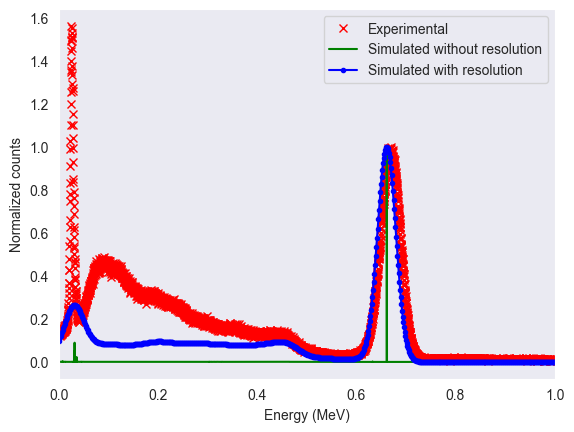

In [21]:
# comparison between experimental data, simulated with Resolution (R) and simulated without-R
g1 = np.histogram(cs_s['5cm'], bins=Energy)
plt.plot(Energy, cs_e['5cm'][2:] / max(cs_e['5cm'][2000:]), 'xr', label='Experimental')
plt.plot(Energy[:-1], g1[0] / max(g1[0]), '-g', label='Simulated without resolution')
plt.plot(data_s_smooth.iloc[0, 0:1500], data_s_smooth.iloc[0, 1500:] / max(data_s_smooth.iloc[0, 1500:]),
         '.-b', label='Simulated with resolution')
plt.grid()
plt.xlabel('Energy (MeV)')
plt.ylabel('Normalized counts')
plt.xlim(0, 1)
plt.legend()
plt.savefig('spectrum_com.jpg', dpi=300)

It was added the effect of the time in the simualation

In [22]:
# determination of time in simulation to get the count rate spectrum
t_simulacion = lambda p, actividad: p / actividad
data_s_s = np.array(data_s_smooth)

In [23]:
# scale simulated spectra acording the activity of each radioative source
for i in range(3):
    data_s_s[i, 1500:] = data_s_s[i, 1500:] / t_simulacion(1e6, activi.iloc[0])
    data_s_s[i + 3, 1500:] = data_s_s[i + 3, 1500:] / t_simulacion(1e6, activi.iloc[2])
    data_s_s[i + 6, 1500:] = data_s_s[i + 6, 1500:] / t_simulacion(1e6, activi.iloc[3] * 0.357)
    data_s_s[i + 9, 1500:] = data_s_s[i + 9, 1500:] / t_simulacion(1e6, activi.iloc[1] * 0.2831)
    data_s_s[i + 12, 1500:] = data_s_s[i + 12, 1500:] / t_simulacion(1e6, activi.iloc[1] * 0.0755)
    data_s_s[i + 15, 1500:] = data_s_s[i + 15, 1500:] / t_simulacion(1e6, activi.iloc[1] * 0.2659)

Even though the simualation was already scaled up, it is still several times higher than experimental data

A function was determined to calculate a factor to scale up again the simulated data

In [24]:
# determination of correction factor
b_cs = f_correcion(cs_e_n, data_s_s[0:3, 1501:], 'Cs')
b_co_1 = f_correcion(co_e_n, data_s_s[3:6, 1501:], 'Co-1')
b_co_2 = f_correcion(co_e_n, data_s_s[3:6, 1501:], 'Co-2')
b_am = f_correcion(am_e_n, data_s_s[6:9, 1501:], 'Am')
b_eu_1 = f_correcion(eu_e_n, data_s_s[9:12, 1501:], 'Eu-1')
b_eu_2 = f_correcion(eu_e_n, data_s_s[12:15, 1501:], 'Eu-2')
b_eu_3 = f_correcion(eu_e_n, data_s_s[15:18, 1501:], 'Eu-3')

It was saved only the mean of the detection correction factor (DCF) and its standard deviation

In [25]:
# determine mean and deviation of each factor
b_am = [b_am.mean(), np.std(b_am)]
b_eu_1 = [b_eu_1.mean(), np.std(b_eu_1)]
b_eu_2 = [b_eu_2.mean(), np.std(b_eu_2)]
b_eu_3 = [b_eu_3.mean(), np.std(b_eu_3)]
b_cs = [b_cs.mean(), np.std(b_cs)]
b_co_1 = [b_co_1.mean(), np.std(b_co_1)]
b_co_2 = [b_co_2.mean(), np.std(b_co_2)]
# save the data in a matrix
fact_c = np.array([b_am, b_eu_1, b_eu_2, b_eu_3, b_cs, b_co_1, b_co_2])


See the results

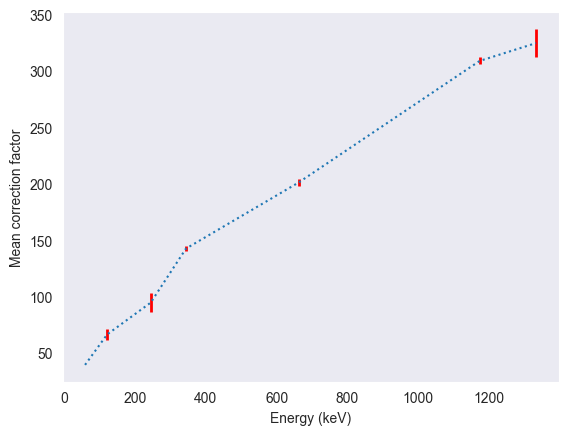

In [26]:
plt.errorbar(e_cab, fact_c[:, 0], yerr=fact_c[:, 1], ecolor='Red', fmt=":", elinewidth=2)
plt.grid(linestyle=':', color='grey', linewidth='1')
plt.xlabel("Energy (keV)")
plt.ylabel("Mean correction factor")
plt.savefig('f_correction.jpg', dpi=300)

Based on the previuos graph, it can be infered that a linear regression can be done to estimate DCF for new energies

In [27]:
# make a linear regresion to predict the detection correction factor
res1 = stats.linregress(e_cab, fact_c[:, 0])
# save values of regression as text
r2_1 = res1[2]
m_1 = res1[0]
b_1 = res1[1]
textstr1 = '\n'.join((
    r'$R^2=%.4f$' % (r2_1,),
    r'$b=%.4f$' % (b_1,),
    r'$m=%.4f$' % (m_1,)))
trans_ene = lambda x: res1[0] * x + res1[1]
ener = np.linspace(0, 2000, 2000, endpoint=True)
r_res = trans_ene(ener)

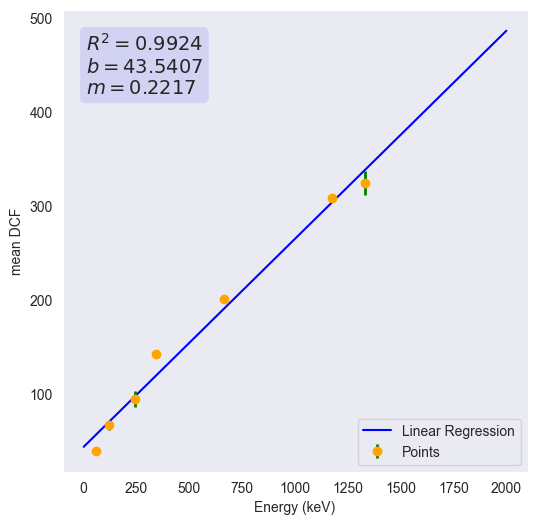

In [28]:
# plot results of regression
fig2 = plt.figure(figsize=(6, 6))
ax = plt.axes()
plt.xlabel('Energy (keV)')
plt.ylabel('mean DCF')
plt.plot(ener, r_res, '-b', label='Linear Regression')
props = dict(boxstyle='round', facecolor='blue', alpha=0.1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.errorbar(e_cab, fact_c[:, 0], yerr=fact_c[:, 1], ecolor='Green', fmt="o", color='orange', elinewidth=2,
             label='Points')
plt.grid(linestyle=':', color='grey', linewidth='1')
plt.legend(loc=4)
plt.savefig('DCF.jpg', dpi=300)

From the results, it can be agreed that the linear regression was succesful due to its regression score (0.99)

Scale up simulated data with DCF

In [29]:
# scale up the simulated spectra with correction factor
for i in range(3):
    # cesium
    data_s_s[i, 1500:] = data_s_s[i, 1500:] / fact_c[4, 0]
    # first peak cobalt
    data_s_s[i + 3, 1500:1500 + 940] = data_s_s[i + 3, 1500:1500 + 940] / fact_c[5, 0]
    data_s_s[i + 3, 1500 + 940:] = data_s_s[i + 3, 1500 + 940:] / fact_c[6, 0]
    # americium
    data_s_s[i + 6, 1500:] = data_s_s[i + 6, 1500:] / fact_c[0, 0]
    # europium first data
    data_s_s[i + 9, 1500:] = data_s_s[i + 9, 1500:] / fact_c[1, 0]
    # europium second data
    data_s_s[i + 12, 1500:] = data_s_s[i + 12, 1500:] / fact_c[2, 0]
    # europium second data
    data_s_s[i + 15, 1500:] = data_s_s[i + 15, 1500:] / fact_c[3, 0]

Once the spectra were scaled up, it's going to be determined the FEPE simulated

In [30]:
# save the FEPE simulated in a matrix
# the column is another isotope
# the row is the distance
eficiencia_sim = np.zeros((3, 7))
area_sim = np.zeros((3, 7))
# first the americium
for i in range(3):
    # add area of americium
    area_sim[i, 0] = np.array([area(data_s_s[i + 6, 1500:], data_s_s[i + 6, :1500], 30, 55)])
    # add first peak of Eu
    area_sim[i, 1] = np.array([area(data_s_s[i + 9, 1500:], data_s_s[i + 9, :1500], 60, 120)])
    # add second peak of Eu
    area_sim[i, 2] = np.array([area(data_s_s[i + 12, 1500:], data_s_s[i + 12, :1500], 150, 210)])
    # add third peak of Eu
    area_sim[i, 3] = np.array([area(data_s_s[i + 15, 1500:], data_s_s[i + 15, :1500], 220, 290)])
    # add the peak of Cs
    area_sim[i, 4] = np.array([area(data_s_s[i, 1500:], data_s_s[i, :1500], 460, 540)])
    # add the first peak of Co
    area_sim[i, 5] = np.array([area(data_s_s[i + 3, 1500:], data_s_s[i + 3, :1500], 840, 920)])
    # add the second peak of Co
    area_sim[i, 6] = np.array([area(data_s_s[i + 3, 1500:], data_s_s[i + 3, :1500], 840, 920)])

In [31]:
# determinate FEPE
for j in range(len(cuentas_t)):
    for i in range(area_sim.shape[0]):
        eficiencia_sim[i, j] = (area_sim[i, j] / cuentas_t[j]) * 100

Determinate the error between FEPE experimental and FEPE simulated

In [32]:
# determinate the error between simulated and experimental FEPE
error = np.zeros((3, 7))
for i in range(3):
    for j in range(7):
        error[i, j] = (np.abs(eficiencia[i, j] - eficiencia_sim[i, j])) / (eficiencia[i, j]) * 100
error_df = pd.DataFrame(error, columns=(
    "Am-241 59 keV", "Eu-152 121 keV", "Eu-152 244 keV", "Eu-152 344 keV", "Cs-137 662 keV", "Co-60 1.17 MeV",
    "Co-60 1.33 MeV"), index=('5 cm', '10 cm', '15 cm'))
error_df

,Am-241 59 keV,Eu-152 121 keV,Eu-152 244 keV,Eu-152 344 keV,Cs-137 662 keV,Co-60 1.17 MeV,Co-60 1.33 MeV
5 cm,4.777142,10.694373,11.060380,2.551565,2.589714,14.586054,2.569365
10 cm,4.401452,1.387955,4.340275,4.447298,3.261595,13.577538,3.588169
15 cm,5.181255,6.374269,9.789713,3.712686,2.971151,12.866439,4.077558


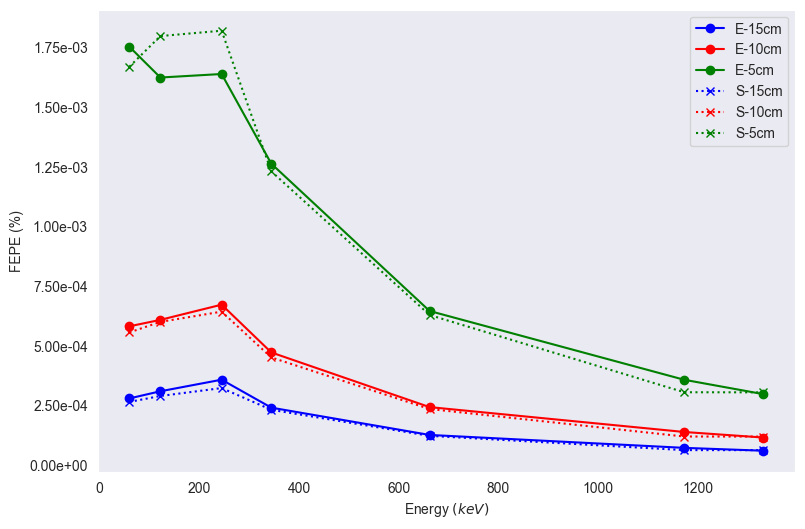

In [33]:
#figure between experimental and simulated FEPE
fig2 = plt.figure(figsize=(9, 6))
ax2 = plt.axes()
ax2.plot(e_cab, eficiencia[2, :], 'o-b', label='E-15cm')
ax2.plot(e_cab, eficiencia[1, :], 'o-r', label='E-10cm')
ax2.plot(e_cab, eficiencia[0, :], 'o-g', label='E-5cm')
ax2.plot(e_cab, eficiencia_sim[2, :], 'x:b', label='S-15cm')
ax2.plot(e_cab, eficiencia_sim[1, :], 'x:r', label='S-10cm')
ax2.plot(e_cab, eficiencia_sim[0, :], 'x:g', label='S-5cm')
plt.legend()
ax2.set_ylabel("FEPE (%)")
ax2.set_xlabel("Energy $(keV)$")
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.2e'))
#plt.title("Curva de calibración de eficiencias")
ax2.grid()
plt.savefig('fepe_curve.png', dpi=500)

The image shows that this methodology is another approach to calibrate radiation detectors with DCF data.

## Radioactive Particle Tracking

Load experimental data of the radioactive particle tracking

In [34]:
# load all the data in np array
files = np.arange(1, 28, 1, dtype=int)
nom_file = []
for i in range(len(files)):
    nom_file.append('pose' + str(files[i]))
data_d1 = []
data_d2 = []
data_o1 = []
data_o2 = []
data_o3 = []
data_o4 = []
data_o5 = []

In [35]:
for i in range(len(files)):
    data_d1.append(np.loadtxt('./RPT-Exp-data/DAQ/DAQ5mms_500/' + nom_file[i] + '.dat'))
    data_d2.append(np.loadtxt('./RPT-Exp-data/DAQ/DAQ60mms_50/' + nom_file[i] + '_v2.dat'))
    data_o1.append(np.loadtxt('./RPT-Exp-data/Osc/5mms_200ms/' + nom_file[i] + '_ov2.dat'))
    data_o2.append(np.loadtxt('./RPT-Exp-data/Osc/60mms_20ms/' + nom_file[i] + '_ov5.dat'))

See how the data looks like

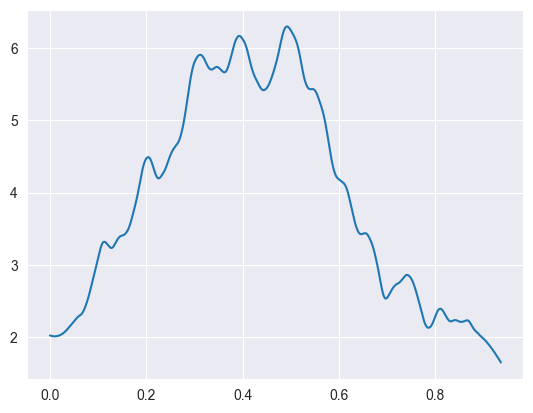

In [36]:
plt.plot(data_o1[0][:, 0], data_o1[0][:, 1])

In [37]:
# transform the data from counts into cps
# determine the time for each velocity
# this operation is made diving the total time with the segment of each vector
for hist in range(27):
    data_d1[hist][:, 1] = data_d1[hist][:, 1] / (196 / len(data_d1[i][:, 1]))
    data_d2[hist][:, 1] = data_d2[hist][:, 1] / (19.6 / len(data_d2[i][:, 1]))
    data_o1[hist][:, 1] = data_o1[hist][:, 1] / (196 / len(data_o1[i][:, 1]))
    data_o2[hist][:, 1] = data_o2[hist][:, 1] / (19.6 / len(data_o2[i][:, 1]))

See the results of the transformation

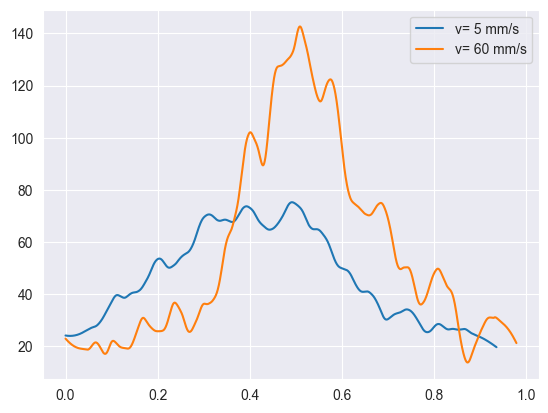

In [38]:
k = 0
plt.plot(data_o1[k][:, 0], data_o1[k][:, 1], label='v= 5 mm/s')
plt.plot(data_o2[k][:, 0], data_o2[k][:, 1], label='v= 60 mm/s')
plt.legend()

In [39]:
# load similated data of the RPT
s_counts = pd.read_csv("result_f.csv", index_col=False)
s_counts[1:28] = s_counts[1:28] / 201.07

In [40]:
# normalize data to compare  between experimental DAQ, experimental Osc, and simulated for 5 mm/s
# save data in new structures
# save data before normalization
from copy import deepcopy

data_n_o1 = deepcopy(data_o1)
data_n_o2 = deepcopy(data_o2)
data_n_d1 = deepcopy(data_d1)
data_n_d2 = deepcopy(data_d2)
data_n_sim = deepcopy(s_counts)

See how simulated data looks like

In [41]:
data_n_sim

,0,1,2,3,4,5,6,7,8,9,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,0.000000,0.000480,0.000960,0.001440,0.001920,0.002400,0.002880,0.003360,0.003840,0.004320,...,0.972432,0.972912,0.973392,0.973872,0.974352,0.974832,0.975312,0.975792,0.976272,0.976752
1,1.881651,1.883215,1.891035,1.897292,1.906677,1.911369,1.914497,1.909805,1.912933,1.912933,...,1.828470,1.831598,1.830034,1.825342,1.828470,1.817521,1.815957,1.809701,1.800316,1.789367
2,1.184048,1.193433,1.191869,1.194997,1.196561,1.198125,1.205946,1.207510,1.207510,1.209074,...,1.252870,1.252870,1.260690,1.260690,1.266947,1.266947,1.266947,1.268511,1.268511,1.273203
3,0.735142,0.735142,0.736706,0.730450,0.733578,0.735142,0.739834,0.739834,0.742963,0.738270,...,0.799271,0.794579,0.793015,0.785194,0.785194,0.789887,0.794579,0.793015,0.791451,0.789887
4,1.634518,1.640774,1.645467,1.656416,1.661108,1.659544,1.668929,1.675185,1.683006,1.687698,...,1.571953,1.576645,1.565696,1.561004,1.546926,1.553183,1.553183,1.554747,1.546926,1.546926
5,1.104277,1.102713,1.101149,1.108970,1.112098,1.124611,1.130867,1.132431,1.133996,1.130867,...,1.144945,1.140252,1.141816,1.137124,1.140252,1.148073,1.144945,1.152765,1.152765,1.146509
6,0.736706,0.733578,0.733578,0.736706,0.736706,0.736706,0.733578,0.735142,0.728885,0.732014,...,0.763296,0.764860,0.761732,0.760168,0.757040,0.755476,0.749219,0.752347,0.763296,0.766425
7,1.510951,1.521900,1.523464,1.518772,1.521900,1.521900,1.526593,1.529721,1.535978,1.540670,...,1.611056,1.609492,1.612620,1.606363,1.617312,1.612620,1.609492,1.595415,1.600107,1.584466
8,1.076123,1.074559,1.072994,1.080815,1.076123,1.074559,1.083943,1.077687,1.076123,1.076123,...,1.124611,1.127739,1.126175,1.123047,1.119918,1.123047,1.118354,1.115226,1.116790,1.107405
9,0.818041,0.819605,0.821169,0.814913,0.808656,0.810220,0.814913,0.816477,0.814913,0.811784,...,0.739834,0.738270,0.738270,0.735142,0.739834,0.747655,0.750783,0.752347,0.758604,0.753912


In [42]:
#normalize data
for i in range(27):
    data_n_o1[i][:, 1] = data_n_o1[i][:, 1] / max(data_n_o1[i][:, 1])
    data_n_o2[i][:, 1] = data_n_o2[i][:, 1] / max(data_n_o2[i][:, 1])
    data_n_d1[i][:, 1] = data_n_d1[i][:, 1] / max(data_n_d1[i][:, 1])
    data_n_d2[i][:, 1] = data_n_d2[i][:, 1] / max(data_n_d2[i][:, 1])
for i in range(1, 27):
    data_n_sim.iloc[i, :] = data_n_sim.iloc[i, :] / max(data_n_sim.iloc[i, :])

In [43]:
# save data before tendency normalization
data_wn_o1 = deepcopy(data_o1)
data_wn_o2 = deepcopy(data_o2)
data_wn_d1 = deepcopy(data_d1)
data_wn_d2 = deepcopy(data_d2)
data_wn_sim = deepcopy(s_counts)

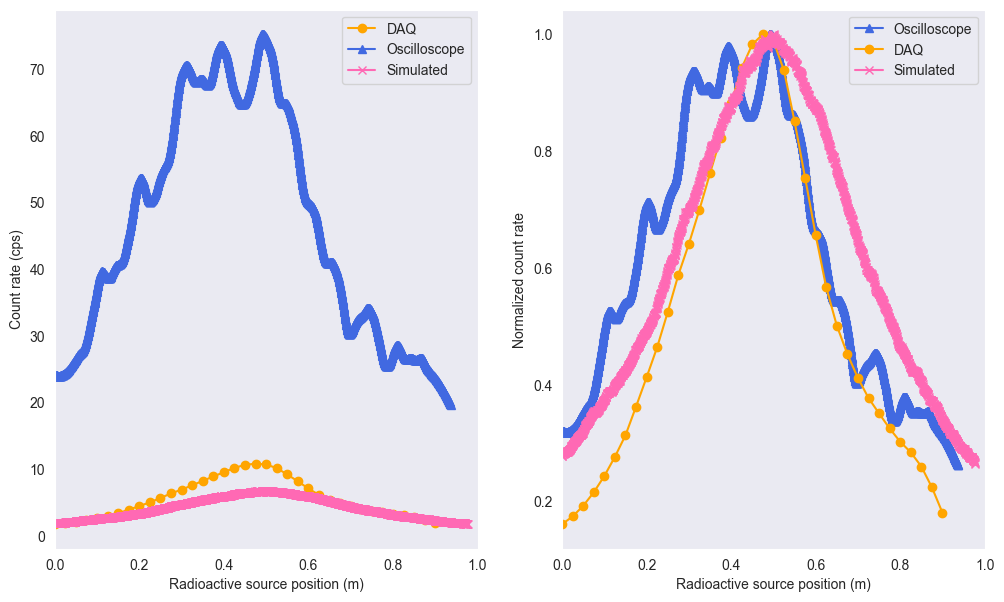

In [44]:
#plot at the same position, and velocity, in order to compare the acquisition system
k = 0
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 7))
# magnitude response
ax1[0].plot(data_d1[k][:, 0], data_d1[k][:, 1], label='DAQ', color='orange', marker='o')
ax1[0].plot(data_o1[k][:, 0], data_o1[k][:, 1], label='Oscilloscope', color='royalblue', marker='^')
ax1[0].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[1], label='Simulated', color='hotpink', marker='x')
ax1[0].set_xlabel('Radioactive source position (m)')
ax1[0].set_ylabel('Count rate (cps)')
ax1[0].set_xlim(0, 1)
ax1[0].grid()
ax1[0].legend()
# tendency response
ax1[1].plot(data_n_o1[k][:, 0], data_n_o1[k][:, 1], label='Oscilloscope', color='royalblue', marker='^')
ax1[1].plot(data_n_d1[k][:, 0], data_n_d1[k][:, 1], label='DAQ', color='orange', marker='o')
ax1[1].plot(data_n_sim.iloc[0], data_n_sim.iloc[1], label='Simulated', color='hotpink', marker='x')
ax1[1].set_xlabel('Radioactive source position (m)')
ax1[1].set_ylabel('Normalized count rate')
ax1[1].set_xlim(0, 1)
ax1[1].grid()
ax1[1].legend()
plt.savefig('daq_vs_osc_5mms.jpg', dpi=300)

In [45]:
# create a function to get values at a defined point
def find_val(x, y, cond):
    if isinstance(x, np.ndarray) == True:
        pass
    else:
        x = np.array(x)
    if isinstance(y, np.ndarray) == True:
        pass
    else:
        y = np.array(y)
    j1 = np.where(x >= cond)
    a = j1[0][0]
    return (y[a])


# create a function to estimate the deviation
def deviation(E, S):
    result = ((E - S) / S) * 100
    return result

In [46]:
# vector of values to evaluate tendency
ten_test = np.array([0.09, 0.19, 0.39, 0.49, 0.59, 0.69, 0.79])
dev_test_equip_ten = np.zeros((7, 3))
dev_test_equip_mag = np.zeros((7, 3))
for i in range(len(ten_test)):
    # column 1 will be Osc experimental
    dev_test_equip_ten[i, 0] = find_val(data_n_o1[0][:, 0], data_n_o1[0][:, 1], ten_test[i])
    # column 2 will be Osc experimental
    dev_test_equip_ten[i, 1] = find_val(data_n_d1[0][:, 0], data_n_d1[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_equip_ten[i, 2] = find_val(data_n_sim.iloc[0], data_n_sim.iloc[1], ten_test[i])
for i in range(len(ten_test)):
    # column 1 will be Osc experimental
    dev_test_equip_mag[i, 0] = find_val(data_wn_o1[0][:, 0], data_wn_o1[0][:, 1], ten_test[i])
    # column 2 will be Osc experimental
    dev_test_equip_mag[i, 1] = find_val(data_wn_d1[0][:, 0], data_wn_d1[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_equip_mag[i, 2] = find_val(data_wn_sim.iloc[0], data_wn_sim.iloc[1], ten_test[i])
deviation_mag = np.zeros((7, 2))
deviation_ten = np.zeros((7, 2))
# determinate the tendecy deviation
for i in range(len(ten_test)):
    # deviation for Osc
    deviation_ten[i, 0] = deviation(dev_test_equip_ten[i, 0], dev_test_equip_ten[i, 2])
    # deviation for DAQ
    deviation_ten[i, 1] = deviation(dev_test_equip_ten[i, 1], dev_test_equip_ten[i, 2])
# determinate the magnitue deviation
for i in range(len(ten_test)):
    # deviation for Osc
    deviation_mag[i, 0] = deviation(dev_test_equip_mag[i, 0], dev_test_equip_mag[i, 2])
    # deviation for DAQ
    deviation_mag[i, 1] = deviation(dev_test_equip_mag[i, 1], dev_test_equip_mag[i, 2])

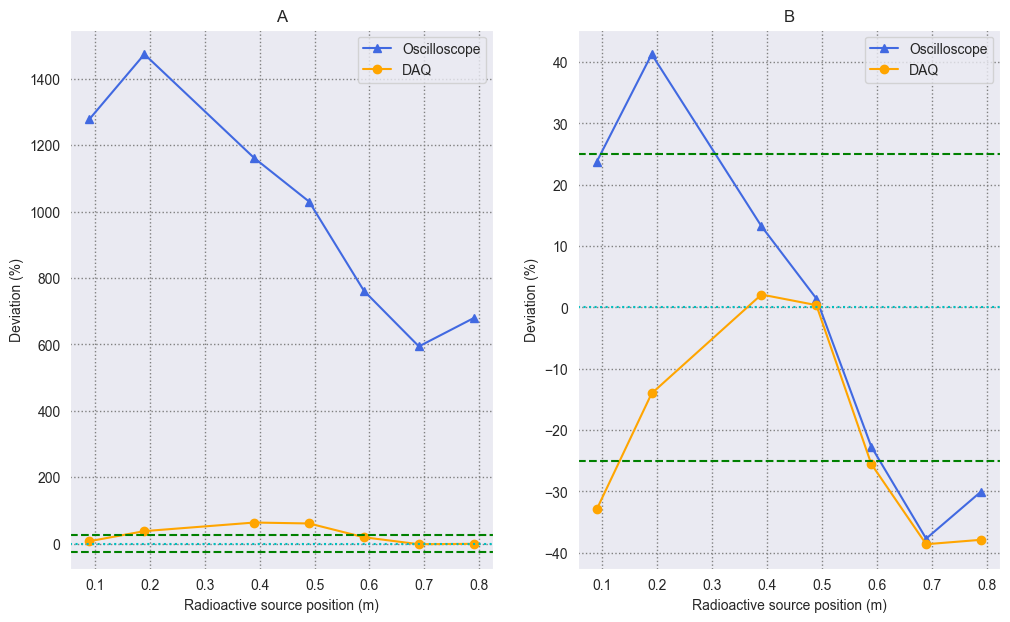

In [47]:
#plot the deviation results
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 7))
ax2[0].plot(ten_test, deviation_mag[:, 0], label='Oscilloscope', color='royalblue', marker='^')
ax2[0].plot(ten_test, deviation_mag[:, 1], label='DAQ', color='orange', marker='o')
ax2[0].set_title('A')
ax2[1].plot(ten_test, deviation_ten[:, 0], label='Oscilloscope', color='royalblue', marker='^')
ax2[1].plot(ten_test, deviation_ten[:, 1], label='DAQ', color='orange', marker='o')
ax2[1].set_title('B')
for i in range(2):
    ax2[i].grid()
    ax2[i].axhline(y=25, xmin=0, xmax=1, ls='--', color='g')
    ax2[i].axhline(y=0, xmin=0, xmax=1, ls=':', color='c')
    ax2[i].axhline(y=-25, xmin=0, xmax=1, ls='--', color='g')
    ax2[i].grid(linestyle=':', color='grey', linewidth='1')
    ax2[i].set_xlabel('Radioactive source position (m)')
    ax2[i].set_ylabel('Deviation (%)')
    ax2[i].legend()
plt.savefig('deviations_acqui_sys.jpg', dpi=300)

Create error

In [48]:
dat_dev = pd.DataFrame()

In [49]:
dat_dev['Energies'] = [0.1,0.2,0.4,0.5, 0.6,0.7,0.8,0.1,0.2,0.4,0.5, 0.6,0.7,0.8]
dat_dev['Mag_dev'] = list(np.concatenate((deviation_mag[:, 0], deviation_mag[:, 1])))
dat_dev['Tend_dev'] = list(np.concatenate((deviation_ten[:, 0], deviation_ten[:, 1])))
dat_dev['Instrument'] = ['Oscilloscope', 'Oscilloscope', 'Oscilloscope', 'Oscilloscope', 'Oscilloscope', 'Oscilloscope', 'Oscilloscope', 'DAQ','DAQ', 'DAQ', 'DAQ', 'DAQ', 'DAQ', 'DAQ' ]

In [50]:
import seaborn as sns

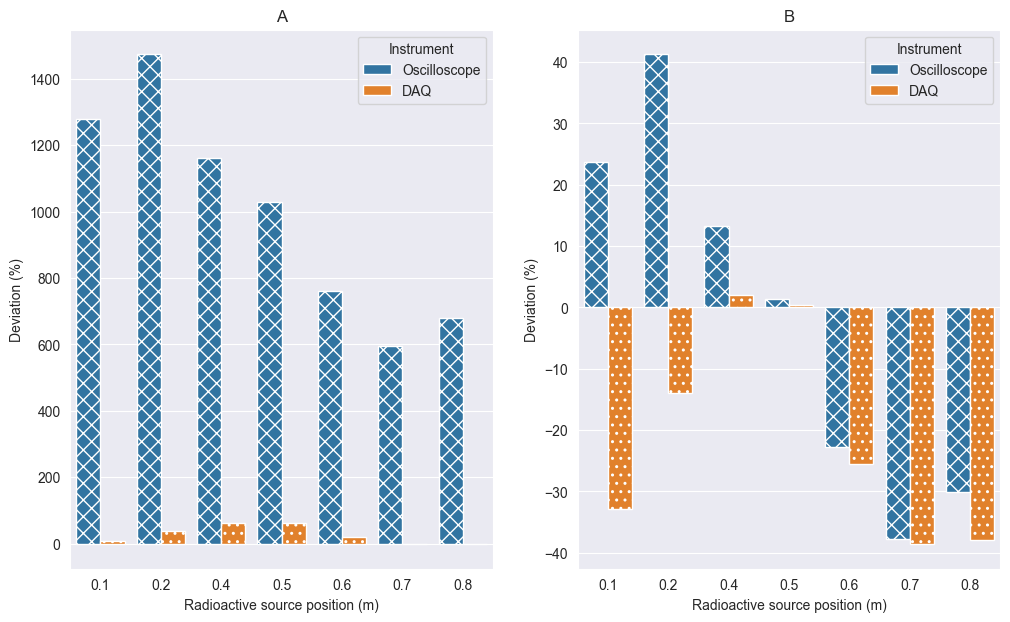

In [67]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
ax = sns.barplot(data = dat_dev, x= 'Energies', y='Mag_dev', hue = 'Instrument')
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
plt.title('A')
plt.subplot(1,2,2)
ax = sns.barplot(data = dat_dev, x= 'Energies', y='Tend_dev', hue = 'Instrument')
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
plt.title('B')
plt.savefig('deviations_acqui_sys_error_bar.jpg', dpi=300)

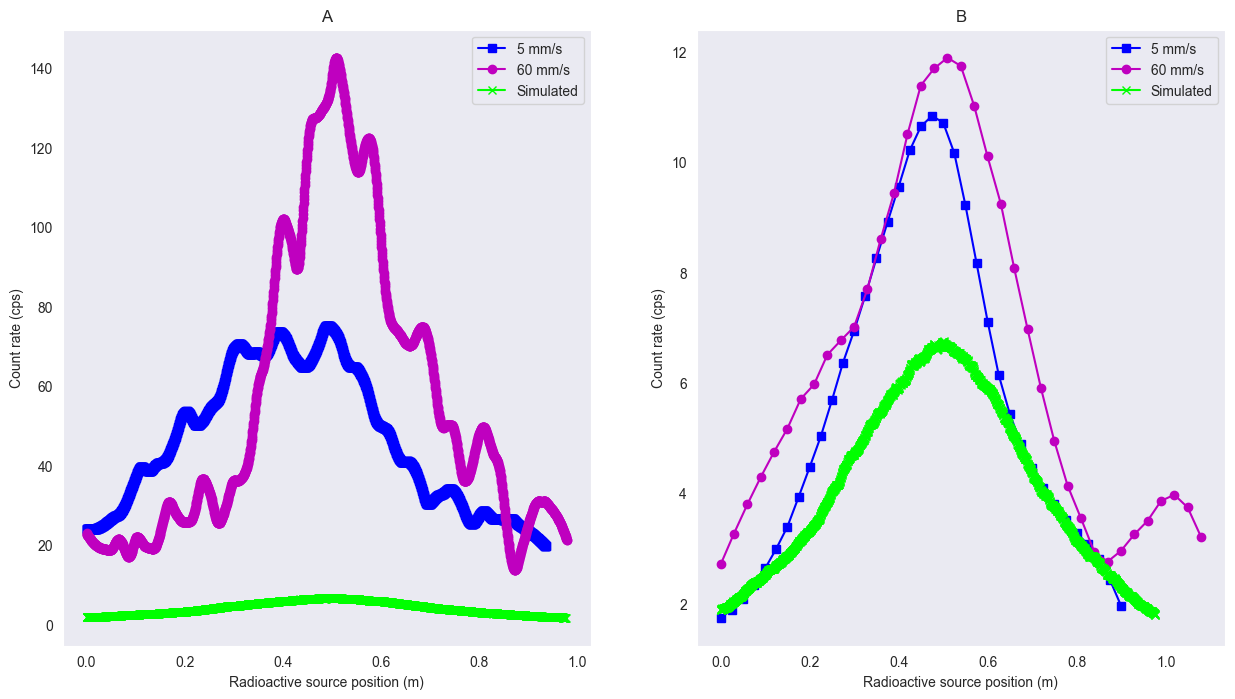

In [52]:
# generate another graph in order to compare the influence of velocity
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 8))
# osc plots
ax1[0].plot(data_o1[k][:, 0], data_o1[k][:, 1], label='5 mm/s', color='b', marker='s')
ax1[0].plot(data_o2[k][:, 0], data_o2[k][:, 1], label='60 mm/s', color='m', marker='o')
ax1[0].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[1], label='Simulated', color='lime', marker='x')
ax1[0].set_xlabel('Radioactive source position (m)')
ax1[0].set_ylabel('Count rate (cps)')
ax1[0].set_title('A')
ax1[0].legend()
ax1[0].grid()
# daq plots
ax1[1].plot(data_d1[k][:, 0], data_d1[k][:, 1], label='5 mm/s', color='b', marker='s')
ax1[1].plot(data_d2[k][:, 0], data_d2[k][:, 1], label='60 mm/s', color='m', marker='o')
ax1[1].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[1], label='Simulated', color='lime', marker='x')
ax1[1].set_xlabel('Radioactive source position (m)')
ax1[1].set_ylabel('Count rate (cps)')
ax1[1].legend()
ax1[1].set_title('B')
ax1[1].grid()
plt.savefig('velo_com_an.jpg', dpi=300)

In [53]:
# deviations for velocities
dev_test_vel_ten_osc = np.zeros((7, 3))
dev_test_vel_ten_daq = np.zeros((7, 3))
dev_test_vel_mag_osc = np.zeros((7, 3))
dev_test_vel_mag_daq = np.zeros((7, 3))
for i in range(len(ten_test)):
    # Oscilloscope
    # column 1 will be 5 mm/s experimental
    dev_test_vel_ten_osc[i, 0] = find_val(data_n_o1[0][:, 0], data_n_o1[0][:, 1], ten_test[i])
    # column 2 will be 60 mm/s experimental
    dev_test_vel_ten_osc[i, 1] = find_val(data_n_o2[0][:, 0], data_n_o2[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_vel_ten_osc[i, 2] = find_val(data_n_sim.iloc[0], data_n_sim.iloc[1], ten_test[i])
    # DAQ
    # column 1 will be 5 mm/s experimental
    dev_test_vel_ten_daq[i, 0] = find_val(data_n_d1[0][:, 0], data_n_d1[0][:, 1], ten_test[i])
    # column 2 will be 60 mm/s experimental
    dev_test_vel_ten_daq[i, 1] = find_val(data_n_d2[0][:, 0], data_n_d2[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_vel_ten_daq[i, 2] = find_val(data_n_sim.iloc[0], data_n_sim.iloc[1], ten_test[i])
for i in range(len(ten_test)):
    # Oscilloscope
    # column 1 will be 5 mm/s experimental
    dev_test_vel_mag_osc[i, 0] = find_val(data_wn_o1[0][:, 0], data_wn_o1[0][:, 1], ten_test[i])
    # column 2 will be 60 mm/s experimental
    dev_test_vel_mag_osc[i, 1] = find_val(data_wn_o2[0][:, 0], data_wn_o2[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_vel_mag_osc[i, 2] = find_val(data_wn_sim.iloc[0], data_wn_sim.iloc[1], ten_test[i])
    # DAQ
    # column 1 will be 5 mm/s experimental
    dev_test_vel_mag_daq[i, 0] = find_val(data_wn_d1[0][:, 0], data_wn_d1[0][:, 1], ten_test[i])
    # column 2 will be 60 mm/s experimental
    dev_test_vel_mag_daq[i, 1] = find_val(data_wn_d2[0][:, 0], data_wn_d2[0][:, 1], ten_test[i])
    # column 3 will be simulated
    dev_test_vel_mag_daq[i, 2] = find_val(data_wn_sim.iloc[0], data_wn_sim.iloc[1], ten_test[i])
deviation_mag_osc = np.zeros((7, 2))
deviation_mag_daq = np.zeros((7, 2))
deviation_ten_osc = np.zeros((7, 2))
deviation_ten_daq = np.zeros((7, 2))
# determinate the tendecy deviation
for i in range(len(ten_test)):
    # for oscilloscope
    # deviation for 5 mm/s
    deviation_ten_osc[i, 0] = deviation(dev_test_vel_ten_osc[i, 0], dev_test_vel_ten_osc[i, 2])
    # deviation for 60 mm.s
    deviation_ten_osc[i, 1] = deviation(dev_test_vel_ten_osc[i, 1], dev_test_vel_ten_osc[i, 2])
    # for DAQ
    # deviation for 5 mm/s
    deviation_ten_daq[i, 0] = deviation(dev_test_vel_ten_daq[i, 0], dev_test_vel_ten_daq[i, 2])
    # deviation for 60 mm.s
    deviation_ten_daq[i, 1] = deviation(dev_test_vel_ten_daq[i, 1], dev_test_vel_ten_daq[i, 2])
# determinate the magnitude deviation
for i in range(len(ten_test)):
    # for oscilloscope
    # deviation for 5 mm/s
    deviation_mag_osc[i, 0] = deviation(dev_test_vel_mag_osc[i, 0], dev_test_vel_mag_osc[i, 2])
    # deviation for 60 mm.s
    deviation_mag_osc[i, 1] = deviation(dev_test_vel_mag_osc[i, 1], dev_test_vel_mag_osc[i, 2])
    # for DAQ
    # deviation for 5 mm/s
    deviation_mag_daq[i, 0] = deviation(dev_test_vel_mag_daq[i, 0], dev_test_vel_mag_daq[i, 2])
    # deviation for 60 mm.s
    deviation_mag_daq[i, 1] = deviation(dev_test_vel_mag_daq[i, 1], dev_test_vel_mag_daq[i, 2])

In [54]:
dev_test_vel_mag_osc

array([[ 33.83758876,  17.76816126,   2.45412294],
       [ 51.04080477,  26.53431662,   3.24244542],
       [ 73.60555015,  96.03623333,   5.83421197],
       [ 75.2274899 , 131.53562567,   6.65538121],
       [ 51.28229595, 112.21547295,   5.95308599],
       [ 31.43431571,  74.19889242,   4.52816183],
       [ 25.64622533,  42.55375924,   3.28936937]])

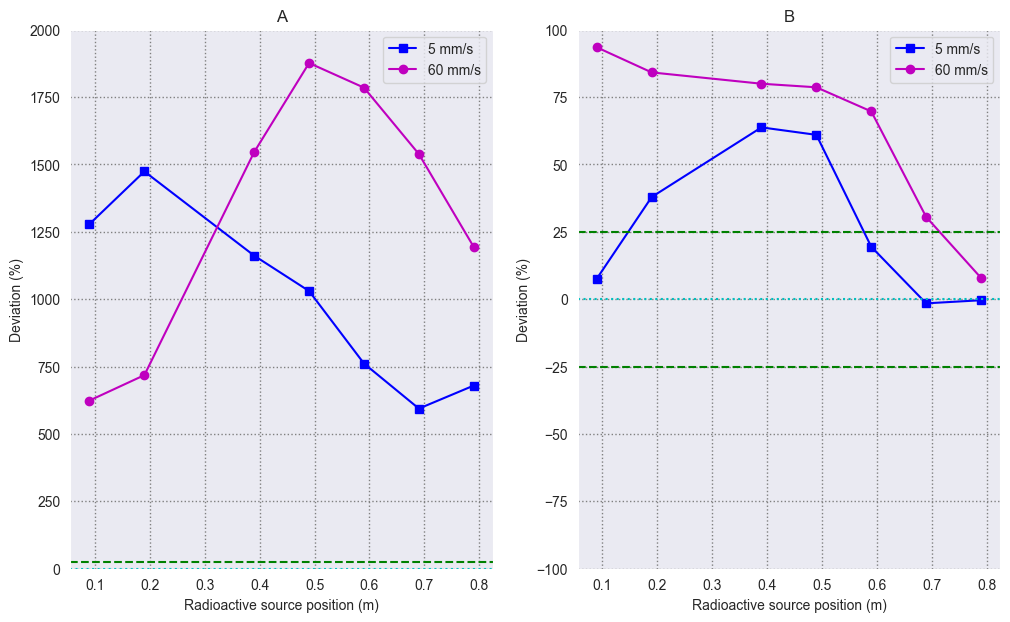

In [55]:
# plot the deviations the first plot for magnitude response
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 7))
# Osc
ax3[0].plot(ten_test, deviation_mag_osc[:, 0], label='5 mm/s', color='b', marker='s')
ax3[0].plot(ten_test, deviation_mag_osc[:, 1], label='60 mm/s', color='m', marker='o')
ax3[0].set_ylim(0, 2e3)
ax3[0].set_title('A')
# DAQ
ax3[1].plot(ten_test, deviation_mag_daq[:, 0], label='5 mm/s', color='b', marker='s')
ax3[1].plot(ten_test, deviation_mag_daq[:, 1], label='60 mm/s', color='m', marker='o')
ax3[1].set_ylim(-100, 100)
ax3[1].set_title('B')
for i in range(2):
    ax3[i].grid()
    ax3[i].axhline(y=25, xmin=0, xmax=1, ls='--', color='g')
    ax3[i].axhline(y=0, xmin=0, xmax=1, ls=':', color='c')
    ax3[i].axhline(y=-25, xmin=0, xmax=1, ls='--', color='g')
    ax3[i].grid(linestyle=':', color='grey', linewidth='1')
    ax3[i].set_xlabel('Radioactive source position (m)')
    ax3[i].set_ylabel('Deviation (%)')
    ax3[i].legend()
plt.savefig('mag_vel_dev.jpg', dpi=300)

In [56]:
dat_dev_vmg = pd.DataFrame()
dat_dev_vmg['Energies'] = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
dat_dev_vmg['Osc'] = list(np.concatenate((deviation_mag_osc[:, 0], deviation_mag_osc[:, 1])))
dat_dev_vmg['Daq'] = list(np.concatenate((deviation_mag_daq[:, 0], deviation_mag_daq[:, 1])))
dat_dev_vmg['Velocity'] = ['5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s',
                         '5 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s']

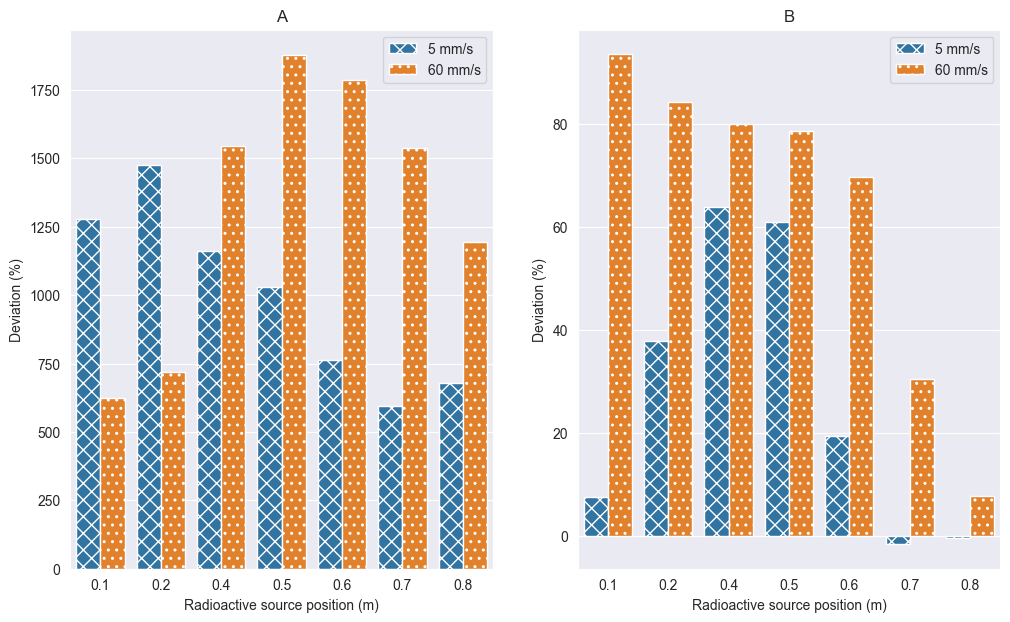

In [57]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
ax = sns.barplot(data = dat_dev_vmg, x= 'Energies', y='Osc', hue = 'Velocity')
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
plt.title('A')
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend()
plt.subplot(1,2,2)
ax = sns.barplot(data = dat_dev_vmg, x= 'Energies', y='Daq', hue = 'Velocity')
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
# plt.ylim(-100,100)
plt.title('B')
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend()
plt.savefig('mag_vel_dev_error_bar.jpg', dpi=300)

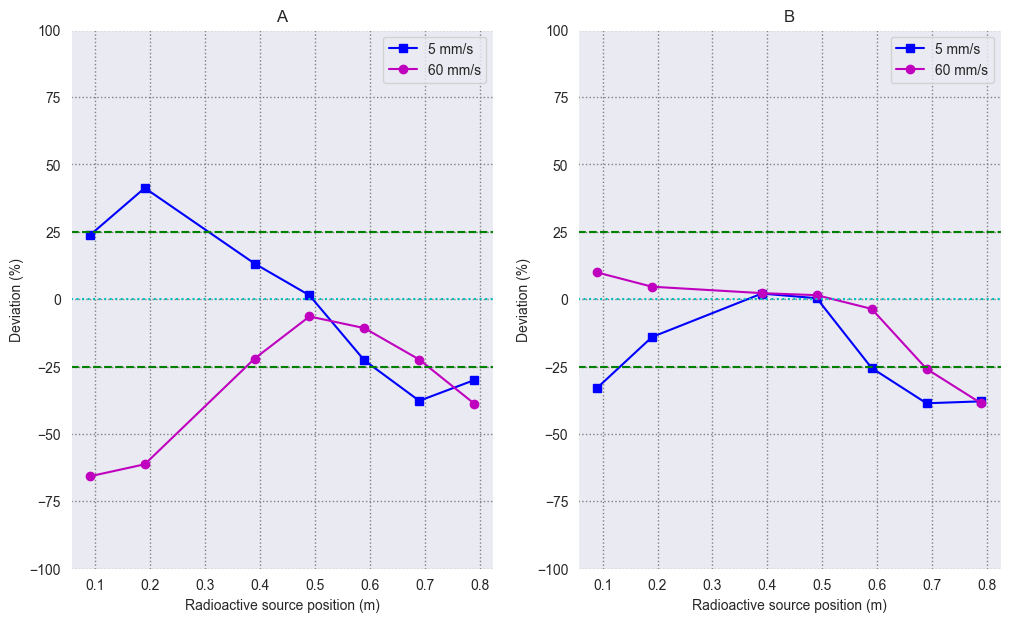

In [58]:
# plot the deviations the second plot for tendency
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 7))
# Osc
ax3[0].plot(ten_test, deviation_ten_osc[:, 0], label='5 mm/s', color='b', marker='s')
ax3[0].plot(ten_test, deviation_ten_osc[:, 1], label='60 mm/s', color='m', marker='o')
ax3[0].set_ylim(-100, 100)
ax3[0].set_title('A')
# DAQ
ax3[1].plot(ten_test, deviation_ten_daq[:, 0], label='5 mm/s', color='b', marker='s')
ax3[1].plot(ten_test, deviation_ten_daq[:, 1], label='60 mm/s', color='m', marker='o')
ax3[1].set_ylim(-100, 100)
ax3[1].set_title('B')
for i in range(2):
    ax3[i].grid()
    ax3[i].axhline(y=25, xmin=0, xmax=1, ls='--', color='g')
    ax3[i].axhline(y=0, xmin=0, xmax=1, ls=':', color='c')
    ax3[i].axhline(y=-25, xmin=0, xmax=1, ls='--', color='g')
    ax3[i].grid(linestyle=':', color='grey', linewidth='1')
    ax3[i].set_xlabel('Radioactive source position (m)')
    ax3[i].set_ylabel('Deviation (%)')
    ax3[i].legend()
plt.savefig('ten_vel_dev.jpg', dpi=300)

In [59]:
dat_dev_vtd = pd.DataFrame()
dat_dev_vtd['Energies'] = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
dat_dev_vtd['Osc'] = list(np.concatenate((deviation_ten_osc[:, 0], deviation_ten_osc[:, 1])))
dat_dev_vtd['Daq'] = list(np.concatenate((deviation_ten_daq[:, 0], deviation_ten_daq[:, 1])))
dat_dev_vtd['Velocity'] = ['5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s', '5 mm/s',
                         '5 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s', '60 mm/s']

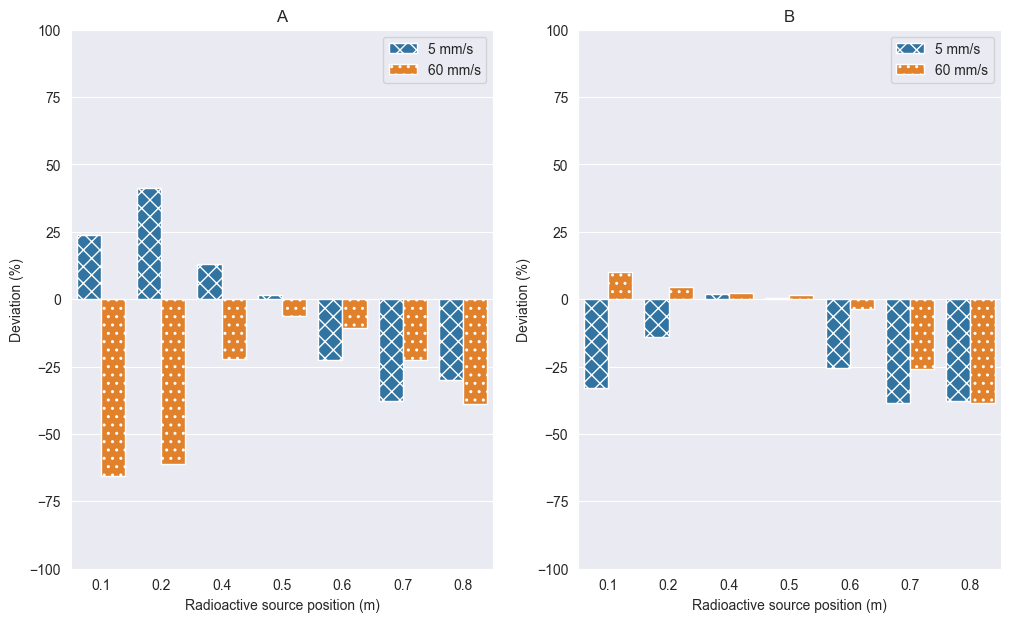

In [60]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
ax = sns.barplot(data = dat_dev_vtd, x= 'Energies', y='Osc', hue = 'Velocity')
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
plt.ylim(-100,100)
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend()
plt.title('A')
plt.subplot(1,2,2)
ax = sns.barplot(data = dat_dev_vtd, x= 'Energies', y='Daq', hue = 'Velocity')
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Deviation (%)')
plt.ylim(-100,100)
hatches = ["xx", ".."]
# Loop over the bars
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend()
plt.title('B')
plt.savefig('ten_vel_dev_error_bar.jpg', dpi=300)

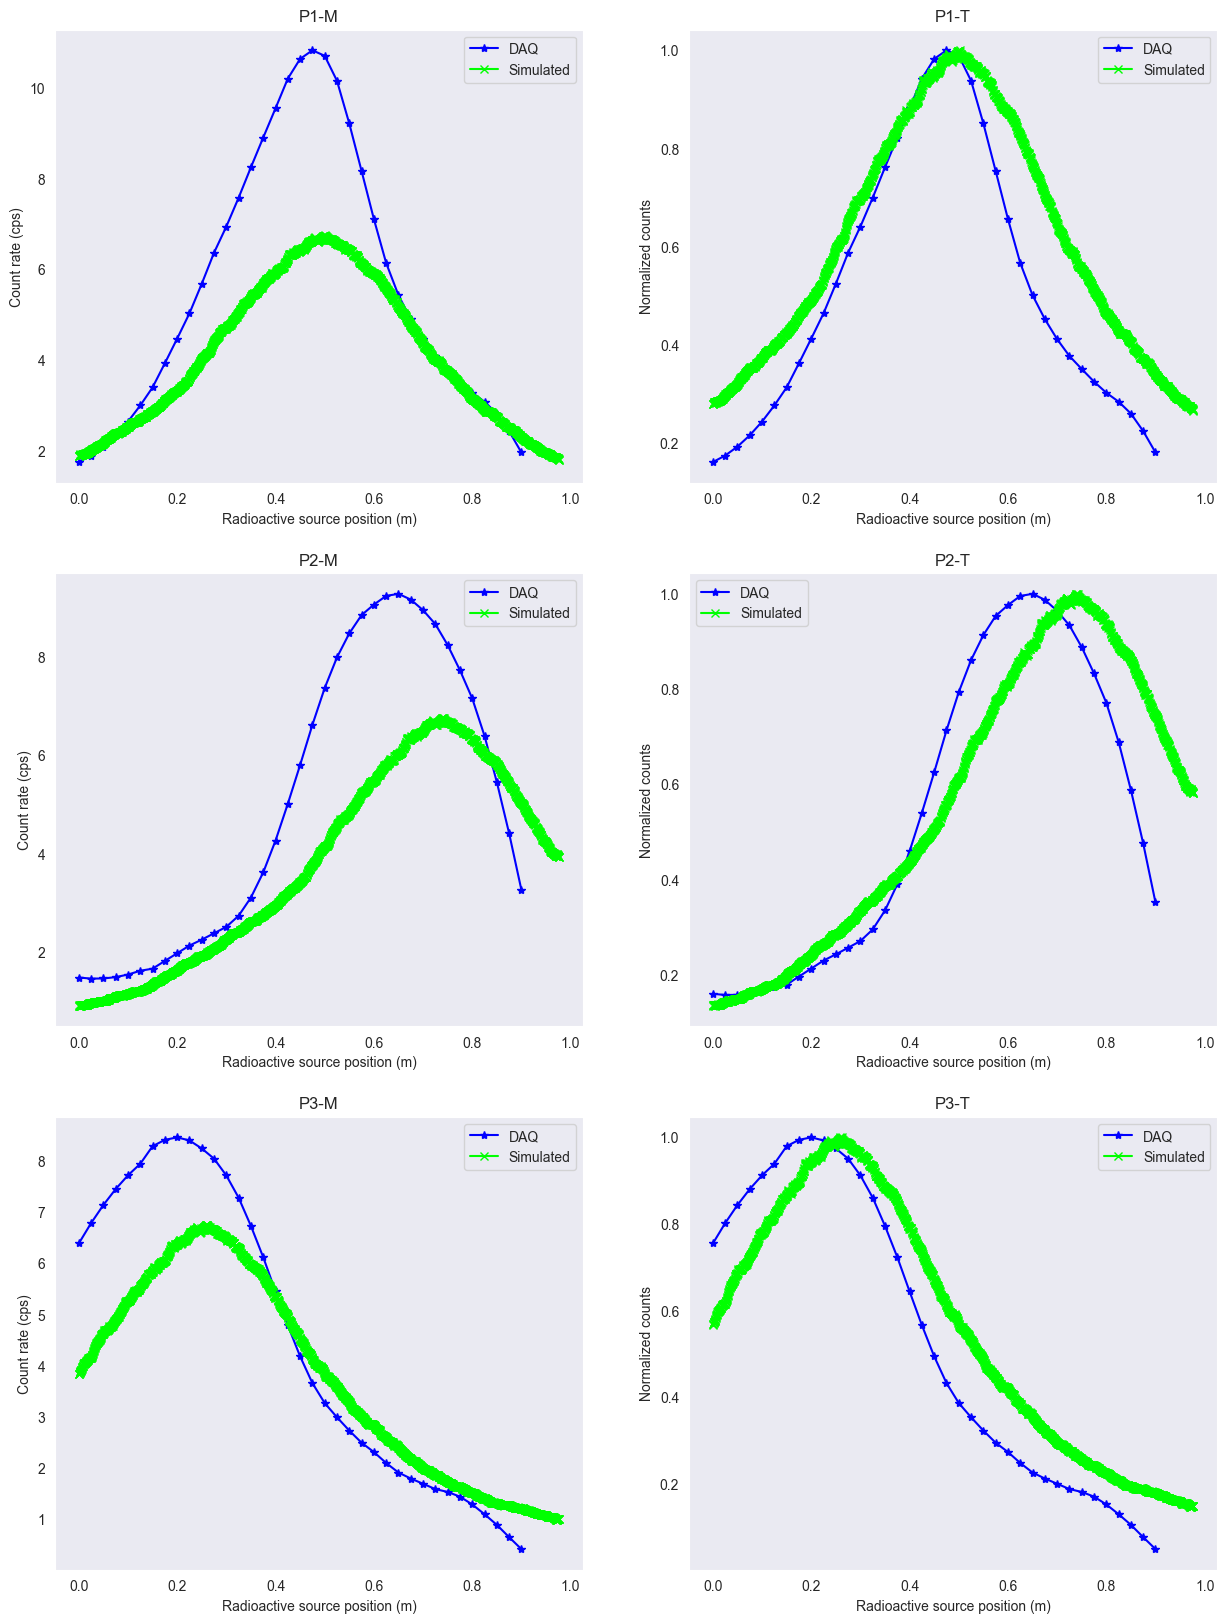

In [61]:
# plot the TC along x axis variation
l2 = np.array(['P1', 'P2', 'P3'])
k = 0
fig4, ax4 = plt.subplots(3, 2, figsize=(15, 20))
for i in range(3):
    #ax4[i, 0].plot(data_o2[k][:, 0], data_o2[k][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 0].plot(data_d1[k][:, 0], data_d1[k][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 0].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[k + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 0].set_ylabel('Count rate (cps)')
    ax4[i, 0].set_title(l2[i] + '-M')
    k = k + 9
k = 0
for i in range(3):
    #ax4[i, 1].plot(data_n_o2[k][:, 0], data_n_o2[k][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 1].plot(data_n_d1[k][:, 0], data_n_d1[k][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 1].plot(data_n_sim.iloc[0], data_n_sim.iloc[k + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 1].set_ylabel('Normalized counts')
    ax4[i, 1].set_title(l2[i] + '-T')
    k = k + 9
for i in range(3):
    for j in range(2):
        ax4[i, j].legend()
        ax4[i, j].grid()
        ax4[i, j].set_xlabel('Radioactive source position (m)')
plt.savefig('var_x_det.jpg', dpi=300)

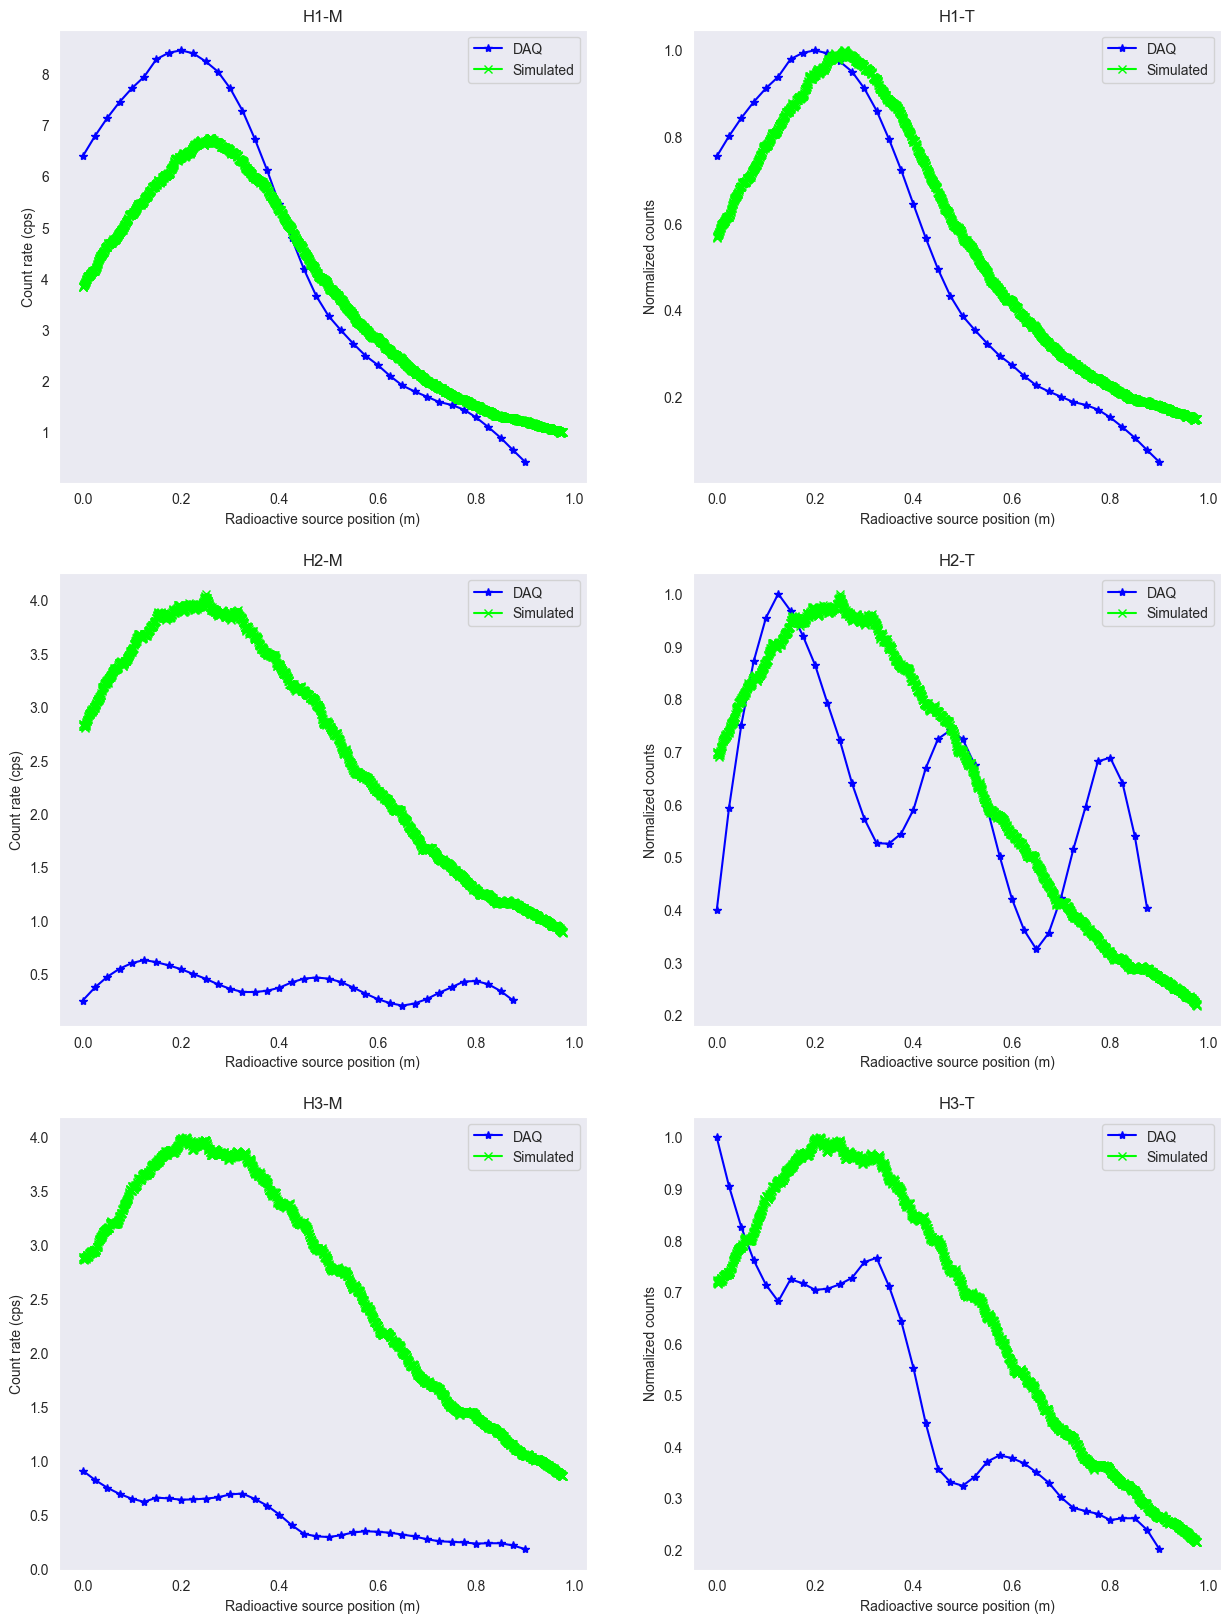

In [62]:
# plot the TC along y axis variation
l3 = np.array(['H1', 'H2', 'H3'])
k = np.array([18, 21, 24])
fig4, ax4 = plt.subplots(3, 2, figsize=(15, 20))
for i in range(3):
    #ax4[i, 0].plot(data_o2[k[i]][:, 0], data_o2[k[i]][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 0].plot(data_d1[k[i]][:, 0], data_d1[k[i]][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 0].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[k[i] + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 0].set_ylabel('Count rate (cps)')
    #ax4[i, 0].set_ylim(0, 10)
    ax4[i, 0].set_title(l3[i] + '-M')

for i in range(3):
    #ax4[i, 1].plot(data_n_o2[k[i]][:, 0], data_n_o2[k[i]][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 1].plot(data_n_d1[k[i]][:, 0], data_n_d1[k[i]][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 1].plot(data_n_sim.iloc[0], data_n_sim.iloc[k[i] + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 1].set_ylabel('Normalized counts')
    ax4[i, 1].set_title(l3[i] + '-T')
for i in range(3):
    for j in range(2):
        ax4[i, j].legend()
        ax4[i, j].grid()
        ax4[i, j].set_xlabel('Radioactive source position (m)')
plt.savefig('var_y_det.jpg', dpi=300)

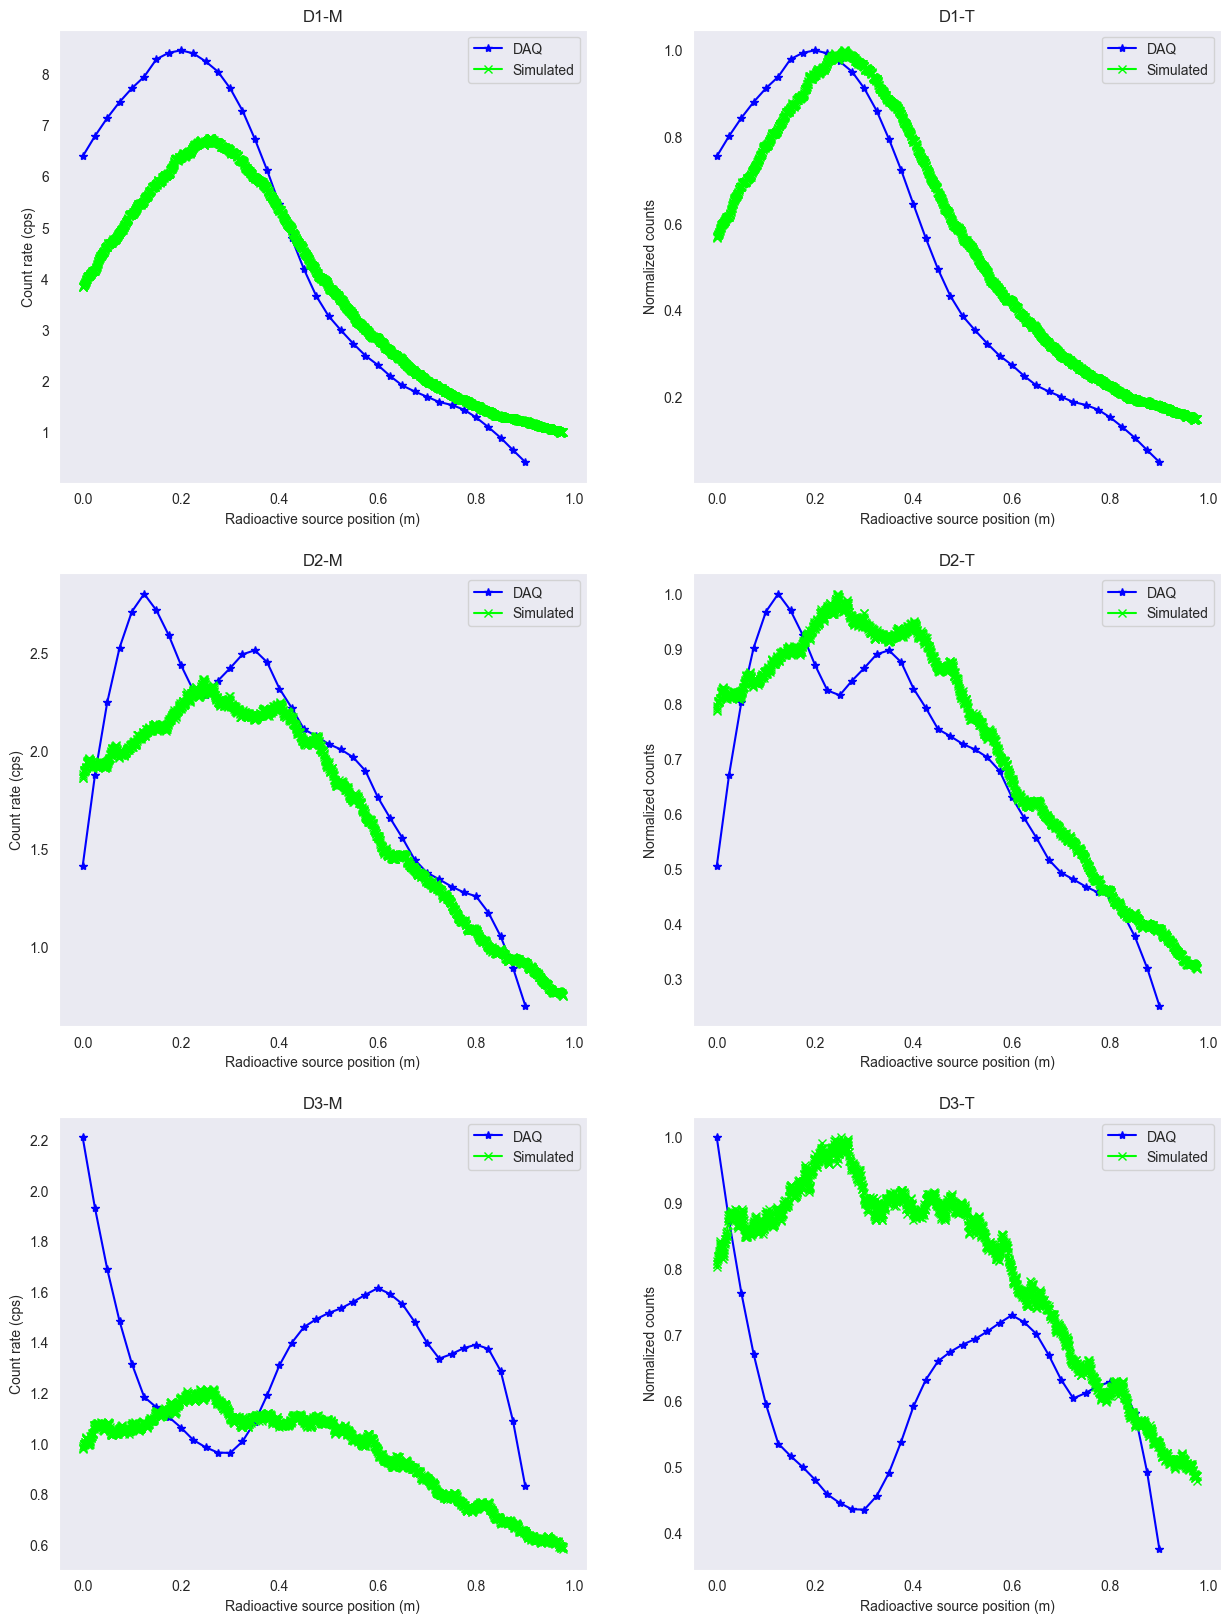

In [63]:
# plot the TC along z axis variation
l3 = np.array(['D1', 'D2', 'D3'])
k = np.array([18, 19, 20])
fig4, ax4 = plt.subplots(3, 2, figsize=(15, 20))
for i in range(3):
    #ax4[i, 0].plot(data_o2[k[i]][:, 0], data_o2[k[i]][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 0].plot(data_d1[k[i]][:, 0], data_d1[k[i]][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 0].plot(data_wn_sim.iloc[0], data_wn_sim.iloc[k[i] + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 0].set_ylabel('Count rate (cps)')
    #ax4[i,0].set_ylim(0,10)
    ax4[i, 0].set_title(l3[i] + '-M')

for i in range(3):
    #ax4[i, 1].plot(data_n_o2[k[i]][:, 0], data_n_o2[k[i]][:, 1], label='Oscilloscope', color='pink', marker='^')
    ax4[i, 1].plot(data_n_d1[k[i]][:, 0], data_n_d1[k[i]][:, 1], label='DAQ', color='b', marker='*')
    ax4[i, 1].plot(data_n_sim.iloc[0], data_n_sim.iloc[k[i] + 1], label='Simulated', color='lime', marker='x')
    ax4[i, 1].set_ylabel('Normalized counts')
    ax4[i, 1].set_title(l3[i] + '-T')
for i in range(3):
    for j in range(2):
        ax4[i, j].legend()
        ax4[i, j].grid()
        ax4[i, j].set_xlabel('Radioactive source position (m)')
plt.savefig('var_z_det.jpg', dpi=300)

In [64]:
# identify maximum values at flatten zones of the TCs
max=[]
max.append(data_n_sim.iloc[19][data_n_sim.iloc[19]==1])
max.append(data_n_sim.iloc[1][data_n_sim.iloc[1]==1])
max.append(data_n_sim.iloc[10][data_n_sim.iloc[10]==1])

See the maxima points

In [65]:
max

[545    1.0
 Name: 19, dtype: float64,
 1045    1.0
 Name: 1, dtype: float64,
 1545    1.0
 Name: 10, dtype: float64]

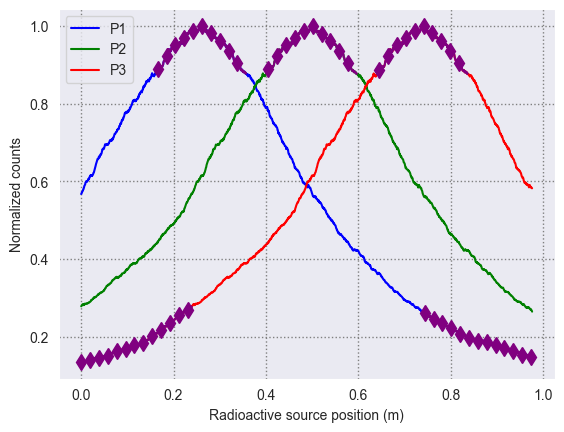

In [94]:
# plot the effective zones, and highligth it
k1=200
k2=200
plt.plot(data_n_sim.iloc[0], data_n_sim.iloc[19], label='P1', color='b')
plt.plot(data_n_sim.iloc[0][545-k1:545+k1], data_n_sim.iloc[19][545-k1:545+k1], color = 'purple', marker = 'd', markersize = 8, markevery = 40)
plt.plot(data_n_sim.iloc[0][1550:], data_n_sim.iloc[19][1550:], color = 'purple', marker = 'd', markersize = 8, markevery = 40)
plt.plot(data_n_sim.iloc[0], data_n_sim.iloc[1], label='P2', color='g')
plt.plot(data_n_sim.iloc[0][1045-k1:1045+k1], data_n_sim.iloc[1][1045-k1:1045+k1], color = 'purple', marker = 'd', markersize = 8, markevery = 40)
plt.plot(data_n_sim.iloc[0], data_n_sim.iloc[10], label='P3', color='r')
plt.plot(data_n_sim.iloc[0][1545-k1:1545+k1], data_n_sim.iloc[10][1545-k1:1545+k1], color = 'purple', marker = 'd', markersize = 8, markevery = 40)
plt.plot(data_n_sim.iloc[0][:500], data_n_sim.iloc[10][:500],color = 'purple', marker = 'd', markersize = 8, markevery = 40)
# plt.vlines(0.25+0.1,0,1,color='b',linestyles='dashed')
# plt.vlines(0.25-0.1,0,1,color='b',linestyles='dashed')
# plt.vlines(0.25+0.5,0,1,color='b',linestyles='dashed')
# plt.vlines(0.5+0.1,0,1,color='g',linestyles='dashed')
# plt.vlines(0.5-0.1,0,1,color='g',linestyles='dashed')
# plt.vlines(0.5+0.5,0,1,color='g',linestyles='dashed')
# plt.vlines(0.75+0.1,0,1,color='r',linestyles='dashed')
# plt.vlines(0.75-0.1,0,1,color='r',linestyles='dashed')
# plt.vlines(0.75-0.5,0,1,color='r',linestyles='dashed')
plt.grid(linestyle=':', color='grey', linewidth='1')
plt.xlabel('Radioactive source position (m)')
plt.ylabel('Normalized counts')
plt.legend(loc=2)
plt.savefig('effective_zone.jpg', dpi=300)

With the results, it can be concluded that at least should be employed 3 detectors.
A detector has two zones, the flat and effective zones.
From the previous picture, the pink zones are the flat zones.
The rest of the zones are the effective zones.